In [1]:

#초기 설정및 시스템 라이브러리
import platform
import warnings

# 데이터 시각화 라이브러리
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
print(platform.system())
warnings.filterwarnings('ignore')

# 행,열,결과값 생략 없이 보기,세팅
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_colwidth', None)

# setting Korean font
import platform
if platform.system() == 'Windows':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif platform.system() == 'Darwin':  # macOS
    plt.rcParams['font.family'] = 'AppleGothic'
else:  # Linux
    plt.rcParams['font.family'] = 'NanumGothic'

# statistic
from scipy import stats
from scipy.stats import shapiro, levene, ttest_ind, chi2_contingency, f_oneway
from scipy.stats import mannwhitneyu, fisher_exact, kruskal
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison
import pingouin as pg
import scikit_posthocs as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

from collections import Counter
from sklearn.datasets import load_diabetes
import scipy.stats as st
from pathlib import Path

# setting seed
np.random.seed(42)

Darwin


In [2]:
# Load Files

import pandas as pd

# 날짜 컬럼 방지
def read_csv_auto_dates(path):
    # 1) 전체 파일을 먼저 읽기
    temp = pd.read_csv(path, low_memory=False)
    
    # 2) _at 로 끝나는 컬럼 자동 탐지
    date_cols = [col for col in temp.columns if col.endswith('_at')]
    
    # 3) 다시 날짜 컬럼을 datetime 으로 읽기
    return pd.read_csv(path, parse_dates=date_cols, low_memory=False)

# Load Files
acq = read_csv_auto_dates("./cleaned_data/clean_acquisitions_final.csv")
deg = read_csv_auto_dates("./cleaned_data/clean_degrees_final.csv")
frs = read_csv_auto_dates("./cleaned_data/clean_fr_final.csv")
fds = read_csv_auto_dates("./cleaned_data/clean_funds_final.csv")
inv = read_csv_auto_dates("./cleaned_data/clean_investments_final.csv")
ipo = read_csv_auto_dates("./cleaned_data/clean_ipos_final.csv")
mil = read_csv_auto_dates("./cleaned_data/clean_milestones_final.csv")
obj= read_csv_auto_dates("./cleaned_data/clean_objects_final.csv")
off = read_csv_auto_dates("./cleaned_data/clean_offices_final.csv")
peo = read_csv_auto_dates("./cleaned_data/clean_people_final.csv")
rel = read_csv_auto_dates("./cleaned_data/clean_relationships_final.csv")
success_master = read_csv_auto_dates("./join_data/success_master.csv")

print("="*60)
print("cleaned dataset 로드 완료!")
print("="*60)

cleaned dataset 로드 완료!


## 통계 조인 테이블 생성

In [ ]:
# funding_rounds ← objects 조인
m1 = (frs
      .merge(obj, how='left', left_on="fr_c_id", right_on="objects_cfpr_id"))
print(f"m1 행수:{m1.shape}")

m1 행수:(52928, 62)


In [ ]:
# objects의 총 투자금이 funding_rounds의 투자금의 총합과 같은지 확인
# objects의 총 투자금이 0값이면서 funding_rounds의 투자금이 0값인 스타트업 id
# 1 차이로 모두 동일
ch = m1[(m1['is_obj_funding_total_usd_private']==0)&(m1['is_fr_raised_private']==0)].groupby('fr_c_id').agg(raised_amount_usd_sum=('raised_amount_usd', 'sum'), funding_total_usd=('funding_total_usd', 'mean'))
ch[ch['raised_amount_usd_sum']<ch['funding_total_usd']]

,raised_amount_usd_sum,funding_total_usd
fr_c_id,,
c:146062,24930754.0,24930755.0
c:149949,629584.0,629585.0
c:151863,110393.0,110394.0
c:16923,949605.0,949606.0
c:169334,390901.0,390902.0
c:17358,15948802.0,15948803.0
c:175964,1917450.0,1917451.0
c:178347,5505903.0,5505904.0
c:179500,623908.0,623909.0


In [ ]:
# objects의 총 투자금과 funding_rounds의 투자금의 총합이 다른 스타트업 개수: 68개
# 하지만 모두 1 차이로 분석결과에 왜곡을 주지 않기 때문에 동일하다고 판단
X = ch[ch['raised_amount_usd_sum']!=ch['funding_total_usd']].count()
X

raised_amount_usd_sum    68
funding_total_usd        68
dtype: int64

In [ ]:
# objects의 총 투자금과 funding_rounds의 투자금의 총합이 동일한 스타트업 개수: 27806개
O = ch[ch['raised_amount_usd_sum']==ch['funding_total_usd']].count()
O

raised_amount_usd_sum    27806
funding_total_usd        27806
dtype: int64

In [ ]:
# raised_amount_usd_sum != funding_total_usd
# 영국인 경우 대부분
target_fr_c_ids = ch[
    ch['raised_amount_usd_sum'] != ch['funding_total_usd']
].index

m1_target = m1[m1['fr_c_id'].isin(target_fr_c_ids)]

m1_target['country_code'].value_counts()

# m1_target[['raised_amount_usd_sum', 'funding_total_usd']]

m1_target

,funding_round_id,fr_c_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,pre_money_valuation_usd,post_money_valuation_usd,participants,is_first_round,is_last_round,funded_year,funded_quarter,cat_fr_type,num_fr_type,log_participants,is_fr_raised_private,objects_cfpr_id,entity_type,parent_c_id,normalized_name,category_code,status,founded_at,closed_at,...,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,is_obj_parent_id_missing,is_obj_category_missing,is_obj_founded_missing,is_obj_closed_missing,is_obj_overview_missing,is_obj_state_missing,is_obj_inv_rounds_missing,is_obj_inv_comp_missing,cat_obj_status,obj_overview_fixed,cat_obj_overview,obj_region_fixed,cat_obj_region,obj_state_filled,obj_city_fixed,obj_category_filled,is_obj_funding_total_usd_private,is_obj_funding_rounds_private
1828,1992,c:4074,2005-06-01,angel,seed,724139.0,NaN,NaN,0,0,1,2005.0,2005Q2,seed,0,0.000000,0,c:4074,Company,NaN,moviestorm,software,operating,2005-06-01,NaT,...,2008-10-01,3.0,5500560.0,2008-12-01,2009-12-22,3.0,6.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,operating,"cambridge uk start up with a digital animated movie software tool called moviestorm - a virtual movie-studio. a public beta version of moviestorm has been available since mid-2007. target market is 16-35, primarily us and other english-speaking. relaunched in january 2010 with a new and redesigned product-offering and publishing platform, with facebook app and 'lite' versions of moviestorm (http://www.moviestorm.co.uk/moviestorm/widgets/). business model is now a free 30-day subscription to the software and platform, upselling to full subscriptions and points-based transactions for content packs providing additional characters, sets, sounds & animations. subsidiary products to attract users include a range of free facebook applications which allow users to create and share movies in a web browser",Software & Technology,london,london,NaN,cambridge,software,0.0,0.0
1829,1993,c:4074,2007-01-20,series-a,seed,1776420.0,NaN,NaN,0,0,0,2007.0,2007Q1,series-a,1,0.000000,0,c:4074,Company,NaN,moviestorm,software,operating,2005-06-01,NaT,...,2008-10-01,3.0,5500560.0,2008-12-01,2009-12-22,3.0,6.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,operating,"cambridge uk start up with a digital animated movie software tool called moviestorm - a virtual movie-studio. a public beta version of moviestorm has been available since mid-2007. target market is 16-35, primarily us and other english-speaking. relaunched in january 2010 with a new and redesigned product-offering and publishing platform, with facebook app and 'lite' versions of moviestorm (http://www.moviestorm.co.uk/moviestorm/widgets/). business model is now a free 30-day subscription to the software and platform, upselling to full subscriptions and points-based transactions for content packs providing additional characters, sets, sounds & animations. subsidiary products to attract users include a range of free facebook applications which allow users to create and share movies in a web browser",Software & Technology,london,london,NaN,cambridge,software,0.0,0.0
2339,2568,c:5171,2006-01-01,angel,seed,1032862.0,NaN,NaN,0,0,1,2006.0,2006Q1,seed,0,0.000000,0,c:5171,Company,NaN,amazingtunes,games_video,operating,2006-01-01,NaT,...,2007-01-01,2.0,2601886.0,NaT,NaT,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,operating,"[amazingtunes](http://www.amazingtunes.com) allows users to find, share, rate and recommend songs. the site also lets artists upload and sell their original works (artists get 70% of the revenue)",Social & Community,newcastle,newcastle,NaN,newcastle upon tyne,games_video,0.0,0.0
2340,2569,c:5171,2007-01-01,series-a,a,1569025.0,NaN,NaN,0,1,0,2007.0,2007Q1,series-a,1,0.000000,0,c:5171,Company,NaN,amazingtunes,games_video,operating,2006-01-01,NaT,...,2007-01-01,2.0,2601886.0,NaT,NaT,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,operating,"[amazingtunes](http://www.amazingtunes.com) allows users to 

In [ ]:
# 총 투자금과 투자금의 합계가 동일한 경우
# raised_amount_usd_sum == funding_total_usd
target_fr_c_ids_1 = ch[
    ch['raised_amount_usd_sum'] == ch['funding_total_usd']
].index

m1_target_2 = m1[m1['fr_c_id'].isin(target_fr_c_ids_1)]

m1_target_2['country_code'].value_counts()

country_code
USA    34432
GBR     2444
CAN     1353
FRA      876
ISR      742
DEU      715
IND      541
ESP      478
CHN      380
SWE      321
IRL      301
AUS      299
NLD      237
ITA      237
CHE      225
SGP      223
RUS      213
JPN      184
BRA      177
BEL      170
DNK      155
FIN      154
AUT      110
ARG      104
NOR       99
KOR       65
HKG       61
MYS       56
TUR       54
POL       53
CHL       52
BGR       48
NZL       45
ZAF       39
GRC       38
MEX       33
PRT       32
EST       31
CZE       29
LUX       29
COL       26
ARE       25
UKR       24
IDN       22
HUN       22
PHL       22
TWN       22
LTU       21
NGA       19
ISL       18
KEN       15
EGY       13
ROM       13
JOR       12
CYP       12
THA       11
SVK       10
ANT        8
CYM        8
BGD        8
PAK        7
VNM        7
LBN        7
HRV        6
PER        6
URY        6
GHA        5
CRI        5
BMU        4
LVA        4
SVN        4
UGA        4
MAR        3
UMI        3
MLT        3
PAN        3

In [ ]:
# obj.obj_city_fixed, off.city 같은 지 비교
import pandas as pd
import unicodedata
import re

# =====================================
# 1. objects - offices 조인
# =====================================
m2 = (
    obj
    .merge(
        off,
        how='left',
        left_on='objects_cfpr_id',
        right_on='offices_c_id'
    )
)

# =====================================
# 2. 기본 필터
#    - 결측 제거
#    - 대소문자/공백 차이 제거 후에도 다른 값
# =====================================
city_check_real = m2[
    m2['obj_city_fixed'].notna() &
    m2['city_y'].notna() &
    (
        m2['obj_city_fixed'].str.strip().str.lower()
        !=
        m2['city_y'].str.strip().str.lower()
    )
].copy()

# =====================================
# 3. 1차 정규화 (소문자 + 공백)
# =====================================
city_check_real['obj_norm'] = (
    city_check_real['obj_city_fixed']
    .str.strip()
    .str.lower()
)

city_check_real['off_norm'] = (
    city_check_real['city_y']
    .str.strip()
    .str.lower()
)

# =====================================
# 4. 고급 정규화 함수
#    - 악센트 제거
#    - 구두점 제거
#    - 공백 정리
# =====================================
def normalize_city(s):
    if pd.isna(s):
        return None
    # 악센트 제거
    s = unicodedata.normalize('NFKD', s)
    s = ''.join(c for c in s if not unicodedata.combining(c))
    # 소문자
    s = s.lower()
    # 구두점 제거
    s = re.sub(r'[^\w\s]', ' ', s)
    # 공백 정리
    s = re.sub(r'\s+', ' ', s).strip()
    return s

city_check_real['obj_norm2'] = city_check_real['obj_norm'].apply(normalize_city)
city_check_real['off_norm2'] = city_check_real['off_norm'].apply(normalize_city)

# =====================================
# 5. 핵심 로직
#    - 서로 포함 관계인 경우 전부 제거
#    - "아예 다른 지역"만 남김
# =====================================
city_check_geo_real = city_check_real[
    city_check_real.apply(
        lambda r: (
            r['obj_norm2'] not in r['off_norm2']
            and
            r['off_norm2'] not in r['obj_norm2']
        ),
        axis=1
    )
].copy()

# =====================================
# 6. 결과 확인
# =====================================
city_check_geo_real[
    ['obj_city_fixed', 'city_y', 'obj_norm2', 'off_norm2']
].value_counts()


obj_city_fixed  city_y       obj_norm2      off_norm2  
new york        London       new york       london         123
san francisco   New York     san francisco  new york       103
so paulo        São Paulo    so paulo       sao paulo      102
london          New York     london         new york        99
telaviv         Tel-Aviv     telaviv        tel aviv        81
                                                          ... 
zurich          NoviSad      zurich         novisad          1
                Muttenz      zurich         muttenz          1
                Mumbai       zurich         mumbai           1
                Milan        zurich         milan            1
abingdon        Lake Forest  abingdon       lake forest      1
Name: count, Length: 12541, dtype: int64

In [ ]:
city_check_geo_real[
    ['obj_city_fixed', 'city_y', 'obj_norm2', 'off_norm2']
]

,obj_city_fixed,city_y,obj_norm2,off_norm2
1,seattle,New York,seattle,new york
7,agadir,Rotterdam,agadir,rotterdam
33,san francisco,New York,san francisco,new york
49,shinagawaku,"Shinagawa-ku, Tokyo",shinagawaku,shinagawa ku tokyo
62,seattle,London,seattle,london
...,...,...,...,...
225850,zurich,Valletta,zurich,valletta
225858,zug,Zurich,zug,zurich
225860,palo alto,San Francisco,palo alto,san francisco
225861,palo alto,Tokyo,palo alto,tokyo


In [ ]:
success_master

,objects_cfpr_id,founded_at,closed_at,description,country_code,obj_city_fixed,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,relationships,cat_obj_status,obj_category_filled,cat_obj_overview,obj_state_filled,is_obj_funding_total_usd_private,success_flag,size_bin,time_to_last_round_months,funding_round_id,fr_c_id,...,is_last_round,funded_year,funded_quarter,cat_fr_type,num_fr_type,log_participants,is_fr_raised_private,prev_round_date,round_tempo_days,round_tempo_months,acquired_c_id,acquisition_id,acquiring_c_id,acquired_at,is_acq_price_private,price_amount_usd,ipos_c_id,ipo_id,first_public_at,valuation_amount_usd,ipo_raised_amount_usd,is_ipos_valuation_private,is_ipos_raised_private,offices_c_id,n_offices
0,c:1,2005-10-17,NaT,Technology Platform Company,USA,seattle,NaT,NaT,0,0,2005-10-01,2008-05-19,3.0,39750000.0,17,operating,web,Software & Technology,WA,0,1,대형팀,32.0,888.0,c:1,...,1.0,2005.0,2005Q4,series-a,1.0,1.098612,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,c:1,2.0
1,c:1,2005-10-17,NaT,Technology Platform Company,USA,seattle,NaT,NaT,0,0,2005-10-01,2008-05-19,3.0,39750000.0,17,operating,web,Software & Technology,WA,0,1,대형팀,32.0,889.0,c:1,...,0.0,2007.0,2007Q1,series-b,2.0,1.386294,0.0,2005-10-01,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,c:1,2.0
2,c:1,2005-10-17,NaT,Technology Platform Company,USA,seattle,NaT,NaT,0,0,2005-10-01,2008-05-19,3.0,39750000.0,17,operating,web,Software & Technology,WA,0,1,대형팀,32.0,2312.0,c:1,...,0.0,2008.0,2008Q2,series-c+,3.0,1.609438,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,c:1,2.0
3,c:1001,2007-10-01,NaT,Social network aggregator,USA,mountain view,NaT,NaT,0,0,NaT,2008-02-26,1.0,5000000.0,14,acquired,web,Software & Technology,CA,0,1,대형팀,NaN,1644.0,c:1001,...,1.0,2008.0,2008Q1,series-a,1.0,1.386294,0.0,NaN,NaN,NaN,c:1001,1901.0,c:5,2009-08-10,0.0,47500000.0,NaN,NaN,NaT,NaN,NaN,NaN,NaN,c:1001,1.0
4,c:10014,2008-03-01,NaT,iPhone Ad Exchange Provider,USA,palo alto,NaT,NaT,0,0,NaT,2008-09-01,NaN,NaN,9,acquired,mobile,Software & Technology,CA,1,1,대형팀,NaN,6682.0,c:10014,...,1.0,2008.0,2008Q3,seed,0.0,0.693147,1.0,NaN,NaN,NaN,c:10014,3878.0,c:23054,2010-09-30,1.0,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,c:10014,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483534,r:9995,NaT,NaT,NaN,NaN,NaN,NaT,NaT,0,0,NaT,NaT,0.0,0.0,0,operating,software,Software & Technology,NaN,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
483535,r:9996,NaT,NaT,NaN,NaN,NaN,NaT,NaT,0,0,NaT,NaT,0.0,0.0,0,operating,software,Software & Technology,NaN,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
483536,r:9997,NaT,NaT,NaN,NaN,NaN,NaT,NaT,0,0,NaT,NaT,0.0,0.0,0,operating,software,Software & Technology,NaN,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN
483537,r:9998,NaT,NaT,NaN,NaN,NaN,NaT,NaT,0,0,NaT,NaT,0.0,0.0,0,operating,software,Software & Technology,NaN,0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN


#### VC_PROFILE 테이블 생성

In [ ]:
# base 생성
base = inv[inv['investor_cfp_id'].str.startswith('f:')]['investor_cfp_id'].drop_duplicates()
# VC id.nunique(): 7671
len(base)
base = base.to_frame(name='investor_cfp_id')
base

,investor_cfp_id
0,f:1
1,f:2
2,f:4
4,f:5
5,f:6
...,...
61337,f:12841
61339,f:15067
61346,f:15069
61395,f:2248


In [ ]:
# base <- success_master 조인
# 조인키: objects_cfpr_id

# 필요한 컬럼 선택
cols_sm = [
    'objects_cfpr_id',
    'description',
    'country_code',
    'obj_city_fixed',
    'first_investment_at',
    'last_investment_at',
    'investment_rounds',
    'invested_companies',
    'relationships',
    'cat_obj_status',
    'obj_category_filled',
    'cat_obj_overview',
    'obj_state_filled',
    'size_bin'
]
success_sel = success_master[cols_sm].copy()

# merge
base_sm = (
    base.merge(
        success_sel,
        left_on='investor_cfp_id',
        right_on='objects_cfpr_id',
        how='left'
    )
    .drop(columns=['objects_cfpr_id'])
)

In [ ]:
base_sm

,investor_cfp_id,description,country_code,obj_city_fixed,first_investment_at,last_investment_at,investment_rounds,invested_companies,relationships,cat_obj_status,obj_category_filled,cat_obj_overview,obj_state_filled,size_bin
0,f:1,VC firm,USA,menlo park,2000-03-01,2013-12-05,307.0,196.0,71.0,operating,software,Software & Technology,CA,NaN
1,f:2,NaN,USA,redwood city,2003-11-01,2013-06-06,52.0,36.0,90.0,operating,software,Software & Technology,CA,NaN
2,f:4,NaN,USA,palo alto,2000-02-15,2013-12-05,479.0,289.0,119.0,operating,software,Software & Technology,CA,NaN
3,f:5,NaN,USA,palo alto,2003-02-01,2013-11-18,64.0,52.0,7.0,operating,software,Software & Technology,CA,NaN
4,f:6,Multi-Stage Venture Capital,USA,san francisco,2005-07-01,2013-12-04,130.0,102.0,32.0,operating,software,Software & Technology,CA,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7666,f:12841,NaN,USA,portland,2013-12-11,2013-12-11,1.0,1.0,1.0,operating,software,Software & Technology,OR,NaN
7667,f:15067,NaN,USA,eden prairie,2013-12-10,2013-12-10,1.0,1.0,0.0,operating,software,Software & Technology,MN,NaN
7668,f:15069,NaN,NaN,NaN,2013-12-11,2013-12-11,1.0,1.0,0.0,operating,software,Software & Technology,NaN,NaN
7669,f:2248,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# =========================================================
# 1. relationships: 회사별 직무 다양성 컬럼 생성
# =========================================================
rel['title_diversity'] = (
    rel.groupby('rel_cf_id')['cat_rel_title']
       .transform('nunique')
)


# =========================================================
# 2. 회사별 대표 1명 선택 (단계적 규칙 적용)
# =========================================================
def select_rep_person(df):
    # 1) sequence 최소
    min_seq = df['sequence'].min()
    df1 = df[df['sequence'] == min_seq]

    # 2) is_past == 0 우선
    if (df1['is_past'] == 0).any():
        df2 = df1[df1['is_past'] == 0]
    else:
        df2 = df1

    # 3) relationship_id 최소
    return df2.loc[df2['relationship_id'].idxmin()]

rel_rep = (
    rel
    .groupby('rel_cf_id', as_index=False, group_keys=False)
    .apply(select_rep_person)
    .reset_index(drop=True)
)

rel_rep


,relationship_id,rel_p_id,rel_cf_id,start_at,end_at,is_past,sequence,title,has_end_date,cat_rel_title,title_diversity
0,73820,p:59304,c:1,NaT,NaT,0,2,"Co-Founder and VP, Social and Audience Development",0,Founder,7
1,136991,p:40235,c:10,2006-06-01,2009-01-01,1,1,VP of Technology,1,VP,4
2,1345,p:1272,c:100,NaT,NaT,0,1,CEO,0,CEO,7
3,2712,p:2706,c:1000,NaT,NaT,0,1,Operations Incharge,0,Sales,1
4,19806,p:16911,c:10002,NaT,NaT,0,1,Founder,0,Founder,2
...,...,...,...,...,...,...,...,...,...,...,...
137176,182517,p:160073,f:9993,NaT,NaT,0,3,NaN,0,NaN,0
137177,182531,p:160088,f:9994,2012-06-12,2012-10-25,1,1,Finance Arranger,1,Sales,1
137178,182532,p:160088,f:9995,2012-10-25,NaT,0,2,NaN,0,NaN,0
137179,182534,p:160094,f:9996,NaT,NaT,0,1,NaN,0,NaN,0


In [ ]:
# base_sm ← relationships merge
base_sm = (
    base_sm
    .merge(
        rel_rep,
        left_on="investor_cfp_id",
        right_on="rel_cf_id",
        how="left"
    )
    .drop(columns=["rel_cf_id"])
)


In [ ]:
base_sm

,investor_cfp_id,description,country_code,obj_city_fixed,first_investment_at,last_investment_at,investment_rounds,invested_companies,relationships,cat_obj_status,obj_category_filled,cat_obj_overview,obj_state_filled,size_bin,relationship_id,rel_p_id,start_at,end_at,is_past,sequence,title,has_end_date,cat_rel_title,title_diversity
0,f:1,VC firm,USA,menlo park,2000-03-01,2013-12-05,307.0,196.0,71.0,operating,software,Software & Technology,CA,NaN,39005.0,p:32797,NaT,NaT,0.0,1.0,Associate Partner,0.0,Partner,13.0
1,f:2,NaN,USA,redwood city,2003-11-01,2013-06-06,52.0,36.0,90.0,operating,software,Software & Technology,CA,NaN,378004.0,p:228205,NaT,NaT,0.0,1.0,Board Member,0.0,Board,16.0
2,f:4,NaN,USA,palo alto,2000-02-15,2013-12-05,479.0,289.0,119.0,operating,software,Software & Technology,CA,NaN,5419.0,p:5172,NaT,NaT,0.0,1.0,Partner,0.0,Partner,19.0
3,f:5,NaN,USA,palo alto,2003-02-01,2013-11-18,64.0,52.0,7.0,operating,software,Software & Technology,CA,NaN,374085.0,p:167018,1999-03-01,NaT,0.0,2.0,Managing Director,0.0,Director,2.0
4,f:6,Multi-Stage Venture Capital,USA,san francisco,2005-07-01,2013-12-04,130.0,102.0,32.0,operating,software,Software & Technology,CA,NaN,40080.0,p:33654,NaT,NaT,0.0,1.0,Partner,0.0,Partner,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7666,f:12841,NaN,USA,portland,2013-12-11,2013-12-11,1.0,1.0,1.0,operating,software,Software & Technology,OR,NaN,330392.0,p:101547,1982-01-01,1994-01-01,1.0,1.0,General Partner,1.0,Partner,1.0
7667,f:15067,NaN,USA,eden prairie,2013-12-10,2013-12-10,1.0,1.0,0.0,operating,software,Software & Technology,MN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
7668,f:15069,NaN,NaN,NaN,2013-12-11,2013-12-11,1.0,1.0,0.0,operating,software,Software & Technology,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
7669,f:2248,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# degrees 최종학력 선택

# =========================================================
# 3. 대표 인물(rel_p_id)만 대상으로 deg 필터링
# =========================================================
rep_p_ids = base_sm['rel_p_id'].dropna().unique()
deg_rep = deg[deg['degrees_p_id'].isin(rep_p_ids)].copy()

# =========================================================
# 4. degrees_p_id별 최종 학위 레벨 선택
# =========================================================
max_level = (
    deg_rep
    .groupby('degrees_p_id')['degree_level']
    .transform('max')
)

final_degree_rows = deg_rep[
    deg_rep['degree_level'] == max_level
].copy()

# =========================================================
# 5. 동일 레벨 복수 학위 → graduated_at 기준 정리
# =========================================================
final_degree_rows['graduated_at'] = pd.to_datetime(
    final_degree_rows['graduated_at'], errors='coerce'
)

# 날짜가 있는 경우: 최신 졸업일
tmp = final_degree_rows.dropna(subset=['graduated_at'])
idx1 = tmp.groupby('degrees_p_id')['graduated_at'].idxmax()

# 날짜가 전부 NaN인 경우: 첫 행
all_na = final_degree_rows.groupby('degrees_p_id')['graduated_at'] \
    .transform(lambda s: s.isna().all())
idx2 = (
    final_degree_rows.loc[all_na]
    .groupby('degrees_p_id')
    .head(1)
    .index
)

idx = pd.Index(idx1).union(idx2)
deg_final_one = final_degree_rows.loc[idx].copy()

# =========================================================
# 6. 안전장치: 그래도 남은 동률 정리
# =========================================================
deg_final_one['degree_level_num'] = pd.to_numeric(
    deg_final_one['degree_level'], errors='coerce'
)
deg_final_one['graduated_at_dt'] = pd.to_datetime(
    deg_final_one['graduated_at'], errors='coerce'
)
deg_final_one['has_grad'] = deg_final_one['graduated_at_dt'].notna().astype(int)
deg_final_one['non_null_cnt'] = deg_final_one.notna().sum(axis=1)

deg_final_sorted = deg_final_one.sort_values(
    by=[
        'degrees_p_id',
        'degree_level_num',
        'has_grad',
        'graduated_at_dt',
        'non_null_cnt'
    ],
    ascending=[True, False, False, False, False],
    kind='mergesort'
)

deg_final_one = (
    deg_final_sorted
    .drop_duplicates(subset=['degrees_p_id'], keep='first')
    .drop(
        columns=[
            'degree_level_num',
            'graduated_at_dt',
            'has_grad',
            'non_null_cnt'
        ],
        errors='ignore'
    )
)

# =========================================================
# 6-1. 최종학력 컬럼명에 `_vc` 접두어 붙이기 (핵심)
# =========================================================
deg_final_one = deg_final_one.rename(
    columns={
        col: f"{col}_vc"
        for col in deg_final_one.columns
        if col != "degrees_p_id"
    }
)

# 검증
assert deg_final_one['degrees_p_id'].is_unique



In [ ]:
# 최종학력 조인
base_sm = base_sm.merge(
    deg_final_one,
    left_on='rel_p_id',
    right_on='degrees_p_id',
    how='left'
)

In [ ]:
# 불필요한 컬럼 제거
drop_cols = [
    "graduated_at_vc",
    "institution_vc",
    "subject_vc",
    "degree_type_vc",
    "has_end_date",
    "title",
    "start_at",
    "end_at"
]

base_sm_clean = base_sm.drop(columns=drop_cols, errors="ignore")

# csv 파일 저장
base_sm_clean.to_csv("./join_data/vc_profile.csv")

### 가설을 위한 테이블 조인

In [ ]:
# Load Files

import pandas as pd

# 날짜 컬럼 방지
def read_csv_auto_dates(path):
    # 1) 전체 파일을 먼저 읽기
    temp = pd.read_csv(path, low_memory=False)
    
    # 2) _at 로 끝나는 컬럼 자동 탐지
    date_cols = [col for col in temp.columns if col.endswith('_at')]
    
    # 3) 다시 날짜 컬럼을 datetime 으로 읽기
    return pd.read_csv(path, parse_dates=date_cols, low_memory=False)

# Load Files
success_master = read_csv_auto_dates("./join_data/success_master.csv")
vc_profile = read_csv_auto_dates("./join_data/vc_profile.csv")
investments_master = read_csv_auto_dates("./join_data/investments_master.csv")

print("="*60)
print("join dataset 로드 완료!")
print("="*60)

join dataset 로드 완료!


In [ ]:
print(f"success_master 행수:{success_master.shape}")
print(f"vc_profile 행수:{vc_profile.shape}")
print(f"investments_master 행수:{investments_master.shape}")

success_master 행수:(483539, 58)
vc_profile 행수:(7671, 27)
investments_master 행수:(80902, 43)


In [ ]:
#########################################
# 변경자: 수아
# 변경일자: 25.12.17
# 변경
# 내용: 1. 통계 분석을 위한 테이블 조인
#      1) VC-창업자의 관계와 투자 성공률 통계 검정
#      2) VC 특징과 투자 성공률 통계 검정
##########################################

# ==========================================
# VC-창업자의 관계 & 투자 성공률 분석을 위한 테이블 조인
# ===========================================

# 겹치는 컬럼명 변경: _vc, _fd prefix 추가

import pandas as pd

# =========================================================
# 0. 조인 키
# =========================================================
join_key = "investor_cfp_id"

# =========================================================
# 1. 조인 전에 삭제할 컬럼 
# =========================================================

# investments_master에서 삭제할 컬럼
drop_cols_fd = [
    "start_at",
    "end_at",
    "degrees_p_id",
    "degree_type",
    "subject",
    "institution",
    "graduated_at"
]

# vc_profile에서 삭제할 컬럼
drop_cols_vc = ["degrees_p_id"]

# 불필요한 컬럼 삭제
investments_master_clean = investments_master.drop(columns=drop_cols_fd, errors="ignore")
vc_profile_clean = vc_profile.drop(columns=drop_cols_vc, errors="ignore")

# =========================================================
# 2. investments_master → 전부 _fd (조인 키 제외)
# =========================================================
investments_master_renamed = investments_master_clean.rename(
    columns={
        col: f"{col}_fd"
        for col in investments_master_clean.columns
        if col != join_key
    }
)

# =========================================================
# 3. vc_profile → _vc 없는 것만 _vc 추가
# =========================================================
vc_profile_renamed = vc_profile_clean.rename(
    columns={
        col: f"{col}_vc"
        for col in vc_profile_clean.columns
        if col != join_key and not col.endswith("_vc")
    }
)

# =========================================================
# 4. merge
# =========================================================
vc_founder_scs = investments_master_renamed.merge(
    vc_profile_renamed,
    on=join_key,
    how="left"
)

# =========================================================
# 5. 최종 검증
# =========================================================
print("행 수:", vc_founder_scs.shape[0])
print("컬럼 수:", vc_founder_scs.shape[1])
print("컬럼 중복 여부:", vc_founder_scs.columns.duplicated().any())

행 수: 80902
컬럼 수: 61
컬럼 중복 여부: False


In [ ]:
import pandas as pd

# =========================================================
# 0. 기본 키 정의
# =========================================================
STARTUP_KEY = "objects_cfpr_id"
INVESTOR_KEY = "investor_cfp_id"
ROUND_KEY = "funding_round_id"

# =========================================================
# 1. inv → VC-라운드 브릿지 생성
# (startup_id는 나중에 success_master 것을 사용)
# =========================================================
obj_frs_inv = inv[
    [INVESTOR_KEY, "invested_c_id", ROUND_KEY]
].rename(
    columns={"invested_c_id": STARTUP_KEY}
)

# VC만 필터링
obj_frs_inv = obj_frs_inv[
    obj_frs_inv[INVESTOR_KEY].str.startswith("f:")
]

print("투자 이벤트–VC 브릿지 행 수:", obj_frs_inv.shape)

# =========================================================
# 2. 재투자 여부 플래그 생성
# (investor, startup 기준)
# =========================================================
obj_frs_inv = obj_frs_inv.sort_values(
    by=[INVESTOR_KEY, STARTUP_KEY, ROUND_KEY]
)

obj_frs_inv["invest_count"] = (
    obj_frs_inv
    .groupby([INVESTOR_KEY, STARTUP_KEY])
    .cumcount()
)

obj_frs_inv["reinvest_flag"] = obj_frs_inv["invest_count"] >= 1
obj_frs_inv = obj_frs_inv.drop(columns="invest_count")

print(
    "VC-스타트업-라운드 중복 여부:",
    obj_frs_inv[[INVESTOR_KEY, STARTUP_KEY, ROUND_KEY]].duplicated().sum()
)

# =========================================================
# 🔴 핵심: startup_id 컬럼 제거 (중복 방지)
# =========================================================
obj_frs_inv = obj_frs_inv.drop(columns=STARTUP_KEY)

# =========================================================
# 3. success_master ← inv (funding_round_id 기준)
# =========================================================
success_master_valid = success_master[
    success_master[ROUND_KEY].notna()
]

print("success_master 유효 투자 이벤트 수:", success_master_valid.shape)

vc_invest_scs = success_master_valid.merge(
    obj_frs_inv,
    on=ROUND_KEY,
    how="left"
)

print("success_master ← inv 조인 후:", vc_invest_scs.shape)

# =========================================================
# 4. vc_profile 전처리
# =========================================================
drop_cols_vc = ["Unnamed: 0", "degrees_p_id"]

vc_profile_clean = vc_profile.drop(
    columns=drop_cols_vc,
    errors="ignore"
)

vc_profile_renamed = vc_profile_clean.rename(
    columns={
        col: f"{col}_vc"
        for col in vc_profile_clean.columns
        if col != INVESTOR_KEY and not col.endswith("_vc")
    }
)

# =========================================================
# 5. VC 프로필 조인
# =========================================================
vc_invest_scs = vc_invest_scs.merge(
    vc_profile_renamed,
    on=INVESTOR_KEY,
    how="left"
)

# =========================================================
# 6. 최종 검증
# =========================================================
print("최종 테이블 행 수:", vc_invest_scs.shape[0])
print("최종 테이블 컬럼 수:", vc_invest_scs.shape[1])
print("컬럼 중복 여부:", vc_invest_scs.columns.duplicated().any())

print(
    "VC 프로필 매칭 실패 비율:",
    vc_invest_scs["country_code_vc"].isna().mean()
)

print(
    "재투자 비율:",
    vc_invest_scs["reinvest_flag"].mean()
)


투자 이벤트–VC 브릿지 행 수: (61403, 3)
VC-스타트업-라운드 중복 여부: 59
success_master 유효 투자 이벤트 수: (52626, 58)
success_master ← inv 조인 후: (86223, 60)
최종 테이블 행 수: 86223
최종 테이블 컬럼 수: 84
컬럼 중복 여부: False
VC 프로필 매칭 실패 비율: 0.3416025886364427
재투자 비율: 0.2513614731712104


In [ ]:
# VC 필터링(nan, c:, p: 제외)
vc_invest_scs = vc_invest_scs[vc_invest_scs['investor_cfp_id'].str.startswith('f:', na=False)]
vc_invest_scs.shape

(61147, 84)

## 통계 검정

### VC-창업자 동일 출신학교 여부와 투자 성공률

In [ ]:
# #############################################################
# # 변경자: 수아
# # 변경일자: 25.12.18
# # 변경
# # 내용: 1. VC 특성에 따른 투자 성공률 통계 검정(사용 테이블: vc_founder_scs)
#        1) 스타트업과 투자자의 관계에 따라 투자 성공률이 달라진다.
#        1-1) VC가 같은 학교 출신의 창업자에게 투자 했을 때 투자 성공률이 높다.
#        1-2) VC와 다른 전공 출신의 창업자에게 투자 했을 때 투자 성공률이 높다.
# ##############################################################

# ============================================================
# 1-1) VC가 같은 학교 출신의 창업자에게 투자 했을 때 투자 성공률이 높다
# H0: VC와 창업자의 출신 학교가 같아도 투자 성공률에는 차이가 없다.
# H1: VC와 창업자의 출신 학교가 같으면 투자 성공률이 더 높다.
# ============================================================
# 검정 방법: 카이제곱
# 종속변수: success_flag_fd
# 독립변수: 같은 학교 여부

#파생변수 : same_school
vc_founder_scs['same_school'] = (vc_founder_scs['institution_normalized_vc']==vc_founder_scs['institution_normalized_fd']).astype(int)
# 둘 중 하나라도 결측이면 NaN
vc_founder_scs.loc[vc_founder_scs[["institution_normalized_vc", "institution_normalized_fd"]].isna().any(axis=1),"same_school"] = pd.NA

print("\n" + "="*80)
print("가설검정 1-1: VC-창업자 동일 학교 여부와 투자 성공의 독립성 검정")
print("="*80)

# =========================================================
# 1. 분석에 필요한 컬럼만 선택 + 결측 제거
# =========================================================
df_chi = vc_founder_scs[
    vc_founder_scs["same_school"].notna() &
    vc_founder_scs["success_flag_fd"].notna()
][["same_school", "success_flag_fd"]]

# =========================================================
# 2. 분할표(Contingency Table) 생성
# =========================================================
contingency_table = pd.crosstab(df_chi['same_school'], df_chi['success_flag_fd'])

print("\n[분할표 (Contingency Table)]")
display(contingency_table)


가설검정 1-1: VC-창업자 동일 학교 여부와 투자 성공의 독립성 검정

[분할표 (Contingency Table)]


success_flag_fd,0.0,1.0
same_school,,
0.0,5955,3480
1.0,305,174


In [ ]:
vc_founder_scs[vc_founder_scs['investor_cfp_id'].str.startswith('c:')]

,funding_round_id_fd,investor_cfp_id,invested_c_id_fd,investments_id_fd,objects_cfpr_id_fd,country_code_fd,obj_city_fixed_fd,funding_rounds_fd,funding_total_usd_fd,relationships_fd,cat_obj_status_fd,obj_category_filled_fd,obj_state_filled_fd,is_obj_funding_total_usd_private_fd,participants_fd,num_fr_type_fd,is_fr_raised_private_fd,cat_fr_type_fd,success_flag_fd,size_bin_fd,reinvest_flag_fd,round_tempo_months_fd,time_to_last_round_months_fd,relationship_id_fd,rel_p_id_fd,...,description_vc,country_code_vc,obj_city_fixed_vc,first_investment_at_vc,last_investment_at_vc,investment_rounds_vc,invested_companies_vc,relationships_vc,cat_obj_status_vc,obj_category_filled_vc,cat_obj_overview_vc,obj_state_filled_vc,size_bin_vc,relationship_id_vc,rel_p_id_vc,is_past_vc,sequence_vc,cat_rel_title_vc,title_diversity_vc,cat_degrees_degree_type_vc,degree_level_vc,is_degree_missing_vc,cat_degrees_subject_vc,institution_normalized_vc,same_school
61403,10,c:2520,c:15,61404,c:15,USA,san francisco,5.0,25762000.0,21.0,operating,news,CA,0.0,1.0,0.0,0.0,seed,1.0,대형팀,True,NaN,NaN,64.0,p:63,...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61404,28,c:1230,c:34,61405,c:34,USA,vienna,6.0,73000000.0,32.0,operating,advertising,VA,0.0,6.0,2.0,0.0,series-b,0.0,대형팀,True,NaN,NaN,11323.0,p:10099,...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61405,29,c:28,c:27,61406,c:27,USA,sunnyvale,4.0,28300000.0,27.0,acquired,web,CA,0.0,4.0,3.0,0.0,series-c+,1.0,대형팀,True,NaN,52.0,101.0,p:100,...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61406,29,c:29,c:27,61407,c:27,USA,sunnyvale,4.0,28300000.0,27.0,acquired,web,CA,0.0,4.0,3.0,0.0,series-c+,1.0,대형팀,True,NaN,52.0,101.0,p:100,...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
61407,33,c:42,c:40,61408,c:40,USA,san diego,4.0,69750000.0,15.0,acquired,games_video,CA,0.0,4.0,2.0,0.0,series-b,1.0,대형팀,True,NaN,NaN,52978.0,p:43520,...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67604,57879,c:285242,c:285244,67605,c:285244,NLD,amsterdam,NaN,NaN,6.0,operating,cleantech,NaN,1.0,5.0,2.0,1.0,series-b,1.0,대형팀,False,NaN,NaN,477902.0,p:15712,...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67605,57882,c:285241,c:285244,67606,c:285244,NLD,amsterdam,NaN,NaN,6.0,operating,cleantech,NaN,1.0,3.0,0.0,1.0,seed,1.0,대형팀,False,NaN,NaN,477902.0,p:15712,...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67606,57886,c:231057,c:286125,67607,c:286125,USA,seattle,1.0,4350000.0,3.0,operating,education,WA,0.0,4.0,1.0,0.0,series-a,0.0,대형팀,False,NaN,0.0,480692.0,p:268491,...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67607,57916,c:286177,c:286178,67608,c:286178,USA,san diego,1.0,17000000.0,2.0,operating,biotech,CA,0.0,3.0,2.0,0.0,series-b,0.0,중형팀,False,NaN,0.0,480837.0,p:149237,...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


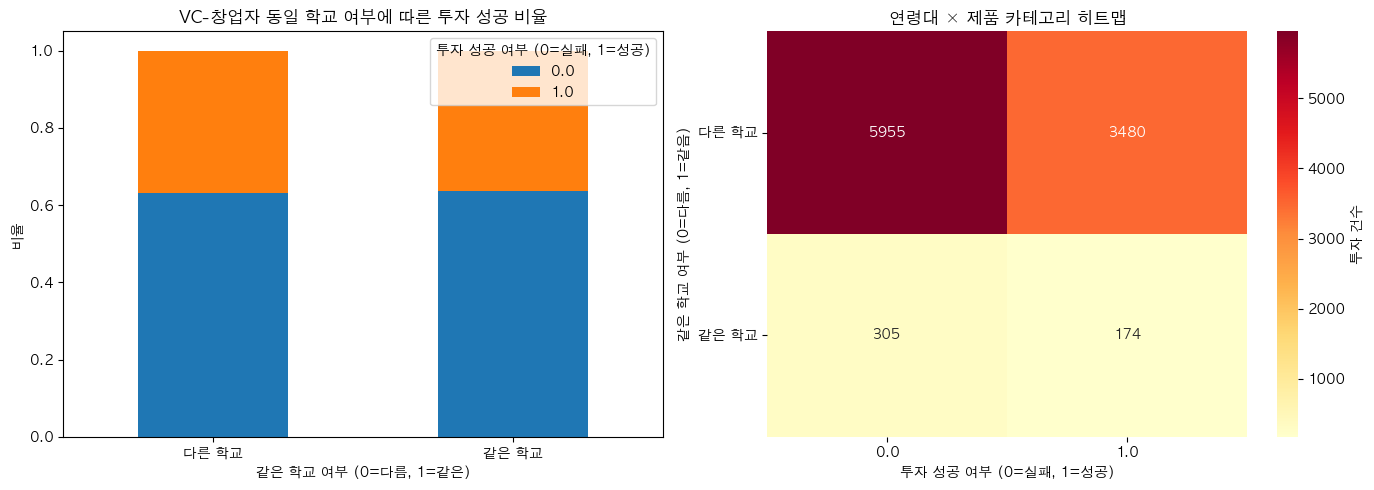

In [ ]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 누적 막대그래프
contingency_table_norm = contingency_table.div(
    contingency_table.sum(axis=1), axis=0
)

contingency_table_norm.plot(
    kind="bar",
    stacked=True,
    ax=axes[0]
)
axes[0].set_title('VC-창업자 동일 학교 여부에 따른 투자 성공 비율')
axes[0].set_xlabel('같은 학교 여부 (0=다름, 1=같은)')
axes[0].set_ylabel('비율')
axes[0].legend(title='투자 성공 여부 (0=실패, 1=성공)')
axes[0].set_xticklabels(["다른 학교", '같은 학교'], rotation=0)

# ---------------------------------------------------------
# 2. 히트맵 (절대 빈도)
# ---------------------------------------------------------
sns.heatmap(contingency_table, annot=True, fmt='d', cmap='YlOrRd', ax=axes[1], 
            cbar_kws={'label': '투자 건수'})
axes[1].set_title('연령대 × 제품 카테고리 히트맵')
axes[1].set_xlabel("투자 성공 여부 (0=실패, 1=성공)")
axes[1].set_ylabel("같은 학교 여부 (0=다름, 1=같음)")
axes[1].set_yticklabels(["다른 학교", "같은 학교"], rotation=0)

plt.tight_layout()
plt.show()

In [ ]:
from scipy.stats import chi2_contingency
import pandas as pd

print("\n" + "="*60)
print("카이제곱 검정: VC–창업자 동일 학교 여부 × 투자 성공")
print("="*60)

# =========================================================
# 가설 설정
# =========================================================
print("H₀: VC–창업자 동일 학교 여부와 투자 성공은 독립적이다")
print("H₁: VC–창업자 동일 학교 여부와 투자 성공은 관련이 있다")
print("유의수준: α = 0.05")

# =========================================================
# 1. 기대빈도 가정 확인
# =========================================================
print("\n[1단계: 기대빈도 가정 확인]")
print("-"*60)

chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)

low_expected = (expected < 5).sum()
total_cells = expected.size
pct_low = (low_expected / total_cells) * 100

print(f"전체 셀 수: {total_cells}개")
print(f"기대빈도 < 5인 셀: {low_expected}개 ({pct_low:.1f}%)")

if pct_low < 20:
    print("✅ 카이제곱 검정 가정 충족 (기대빈도 < 5인 셀이 20% 미만)")
elif pct_low < 50:
    print("⚠️ 주의: 기대빈도 < 5인 셀이 20–50% → 결과 해석 시 주의")
else:
    print("❌ 가정 위반: 기대빈도 < 5인 셀이 50% 이상 → Fisher Exact Test 또는 범주 통합 권장")

# =========================================================
# 기대빈도 테이블 출력
# =========================================================
expected_df = pd.DataFrame(
    expected,
    index=contingency_table.index,
    columns=contingency_table.columns
)

print("\n[기대빈도 테이블]")
display(expected_df.round(2))



카이제곱 검정: VC–창업자 동일 학교 여부 × 투자 성공
H₀: VC–창업자 동일 학교 여부와 투자 성공은 독립적이다
H₁: VC–창업자 동일 학교 여부와 투자 성공은 관련이 있다
유의수준: α = 0.05

[1단계: 기대빈도 가정 확인]
------------------------------------------------------------
전체 셀 수: 4개
기대빈도 < 5인 셀: 0개 (0.0%)
✅ 카이제곱 검정 가정 충족 (기대빈도 < 5인 셀이 20% 미만)

[기대빈도 테이블]


success_flag_fd,0.0,1.0
same_school,,
0.0,5957.54,3477.46
1.0,302.46,176.54


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Cramér's V 계산 함수
def cramers_v(chi2, n, r, c):
    return np.sqrt(chi2 / (n * (min(r - 1, c - 1))))

# Cramér's V 해석 함수
def interpret_cramers_v(v):
    if v < 0.1:
        return "효과 매우 약함"
    elif v < 0.3:
        return "약한 효과"
    elif v < 0.5:
        return "중간 효과"
    else:
        return "강한 효과"


# ====== 2. 카이제곱 검정 수행 ======
print("\n[2단계: 카이제곱 독립성 검정]")
print("-"*60)

print(f"카이제곱 통계량 (χ²): {chi2_stat:.4f}")
print(f"자유도 (df): {dof}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("➡ 귀무가설 기각: 동일 학교 여부와 투자 성공은 통계적으로 관련 있음")
else:
    print("➡ 귀무가설 채택: 동일 학교 여부와 투자 성공은 독립적임")

# ====== 3. 효과 크기 (Cramér's V) ======
print("\n[3단계: 효과 크기 (Cramér's V)]")
print("-"*60)

n = contingency_table.values.sum()
r, c = contingency_table.shape

v = cramers_v(chi2_stat, n, r, c)
print(f"Cramér's V: {v:.3f} → {interpret_cramers_v(v)}")

# ====== 4. 표준화 잔차 분석 (사후검정) ======
if p_value < 0.05:
    print("\n[4단계: 표준화 잔차 분석]")
    print("-"*60)
    print("카이제곱 검정이 유의하므로, 어떤 셀이 차이를 만드는지 분석")

    # -------------------------------------------------
    # 표준화 잔차 계산
    # -------------------------------------------------
    std_residuals = (contingency_table.values - expected) / np.sqrt(expected)

    residuals_df = pd.DataFrame(
        std_residuals,
        index=contingency_table.index,
        columns=contingency_table.columns
    )

    print("\n[표준화 잔차 테이블]")
    display(residuals_df.round(2))
    print("(|잔차| > 2: 유의한 차이, |잔차| > 3: 매우 강한 연관성)")

    # -------------------------------------------------
    # 히트맵 시각화
    # -------------------------------------------------
    print("\n[표준화 잔차 히트맵]")
    plt.figure(figsize=(8, 5))

    sns.heatmap(
        residuals_df,
        annot=True,
        fmt=".1f",
        cmap="RdBu_r",
        center=0,
        vmin=-4,
        vmax=4,
        cbar_kws={"label": "표준화 잔차"}
    )

    plt.title(
        "VC–창업자 동일 학교 여부 × 투자 성공\n(표준화 잔차 히트맵)",
        fontsize=12,
        fontweight="bold"
    )
    plt.xlabel("투자 성공 여부 (0=실패, 1=성공)")
    plt.ylabel("같은 학교 여부 (0=다름, 1=같음)")
    plt.yticks(rotation=0)

    # -------------------------------------------------
    # |잔차| > 2 인 셀 강조
    # -------------------------------------------------
    ax = plt.gca()
    for i in range(residuals_df.shape[0]):
        for j in range(residuals_df.shape[1]):
            if abs(std_residuals[i, j]) > 2:
                ax.add_patch(
                    plt.Rectangle(
                        (j, i), 1, 1,
                        fill=False,
                        edgecolor="black",
                        lw=2
                    )
                )

    plt.tight_layout()
    plt.show()



[2단계: 카이제곱 독립성 검정]
------------------------------------------------------------
카이제곱 통계량 (χ²): 0.0394
자유도 (df): 1
p-value: 0.8426
➡ 귀무가설 채택: 동일 학교 여부와 투자 성공은 독립적임

[3단계: 효과 크기 (Cramér's V)]
------------------------------------------------------------
Cramér's V: 0.002 → 효과 매우 약함


### VC-창업자의 전공 동일 여부에 따른 투자 성공률

In [ ]:
vc_founder_scs

,funding_round_id_fd,investor_cfp_id,invested_c_id_fd,investments_id_fd,objects_cfpr_id_fd,country_code_fd,obj_city_fixed_fd,funding_rounds_fd,funding_total_usd_fd,relationships_fd,cat_obj_status_fd,obj_category_filled_fd,obj_state_filled_fd,is_obj_funding_total_usd_private_fd,participants_fd,num_fr_type_fd,is_fr_raised_private_fd,cat_fr_type_fd,success_flag_fd,size_bin_fd,reinvest_flag_fd,round_tempo_months_fd,time_to_last_round_months_fd,relationship_id_fd,rel_p_id_fd,...,description_vc,country_code_vc,obj_city_fixed_vc,first_investment_at_vc,last_investment_at_vc,investment_rounds_vc,invested_companies_vc,relationships_vc,cat_obj_status_vc,obj_category_filled_vc,cat_obj_overview_vc,obj_state_filled_vc,size_bin_vc,relationship_id_vc,rel_p_id_vc,is_past_vc,sequence_vc,cat_rel_title_vc,title_diversity_vc,cat_degrees_degree_type_vc,degree_level_vc,is_degree_missing_vc,cat_degrees_subject_vc,institution_normalized_vc,same_school
0,1,f:1,c:4,1,c:4,USA,san francisco,4.0,4.500000e+07,57.0,acquired,news,CA,0.0,2.0,2.0,0.0,series-b,1.0,대형팀,True,14.0,70.0,123200.0,p:23147,...,VC firm,USA,menlo park,2000-03-01,2013-12-05,307.0,196.0,71.0,operating,software,Software & Technology,CA,NaN,39005.0,p:32797,0.0,1.0,Partner,13.0,Master’s degree,3.0,0.0,NaN,harvard university,NaN
1,1,f:2,c:4,2,c:4,USA,san francisco,4.0,4.500000e+07,57.0,acquired,news,CA,0.0,2.0,2.0,0.0,series-b,1.0,대형팀,True,14.0,70.0,123200.0,p:23147,...,NaN,USA,redwood city,2003-11-01,2013-06-06,52.0,36.0,90.0,operating,software,Software & Technology,CA,NaN,378004.0,p:228205,0.0,1.0,Board,16.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,f:4,c:5,3,c:5,USA,menlo park,11.0,2.425700e+09,269.0,ipo,social,CA,0.0,3.0,1.0,0.0,series-a,1.0,대형팀,True,1.0,NaN,9.0,p:10,...,NaN,USA,palo alto,2000-02-15,2013-12-05,479.0,289.0,119.0,operating,software,Software & Technology,CA,NaN,5419.0,p:5172,0.0,1.0,Partner,19.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,f:1,c:5,4,c:5,USA,menlo park,11.0,2.425700e+09,269.0,ipo,social,CA,0.0,4.0,2.0,0.0,series-b,1.0,대형팀,True,1.0,NaN,9.0,p:10,...,VC firm,USA,menlo park,2000-03-01,2013-12-05,307.0,196.0,71.0,operating,software,Software & Technology,CA,NaN,39005.0,p:32797,0.0,1.0,Partner,13.0,Master’s degree,3.0,0.0,NaN,harvard university,NaN
4,4,f:5,c:5,5,c:5,USA,menlo park,11.0,2.425700e+09,269.0,ipo,social,CA,0.0,4.0,2.0,0.0,series-b,1.0,대형팀,True,1.0,NaN,9.0,p:10,...,NaN,USA,palo alto,2003-02-01,2013-11-18,64.0,52.0,7.0,operating,software,Software & Technology,CA,NaN,374085.0,p:167018,0.0,2.0,Director,2.0,Master’s degree,3.0,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80897,57882,p:267312,c:285244,80898,c:285244,NLD,amsterdam,NaN,NaN,6.0,operating,cleantech,NaN,1.0,3.0,0.0,1.0,seed,1.0,대형팀,False,NaN,NaN,477902.0,p:15712,...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80898,57912,p:268570,c:60389,80899,c:60389,DEU,cologne,NaN,NaN,3.0,operating,cleantech,NaN,1.0,1.0,3.0,1.0,series-c+,0.0,대형팀,False,NaN,NaN,90670.0,p:73372,...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80899,57929,p:365,c:286183,80900,c:286183,USA,NaN,1.0,2.250000e+05,2.0,operating,web,CA,0.0,3.0,0.0,0.0,seed,0.0,중형팀,True,NaN,0.0,480841.0,p:268576,...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
80900,57929,p:176466,c:286183,80901,c:286183,USA,NaN,1.0,2.250000e+05,2.0,operating,web,CA,0.0,3.0,0.0,0.0,seed,0.0,중형팀,False,NaN,0.0,480841.0,p:268576,...,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# ============================================================
# 1-2) VC가 다른 전공 출신의 창업자에게 투자 했을 때 투자 성공률이 높다
# H0: VC와 창업자의 전공 동일 여부는 투자 성공률에 영향을 주지 않는다.
# H1: VC와 창업자의 전공 동일 여부는 투자 성공률에 영향을 준다.
# ============================================================
# 검정 방법: 로지스틱 회귀
# 종속변수: success_flag_fd
# 독립변수: 같은 전공 여부

df = vc_founder_scs.copy()

# ==========================================
# 파생변수: 같은 전공 여부 (동일 전공:1 , 다른 전공:0)
# ==========================================
df['same_major'] = (df['cat_degrees_subject_vc']==df['cat_degrees_subject_fd']).astype(int)

# ===========================
# 결측 제거(비교 불가능한 경우 제거)
# ===========================
df = df.dropna(subset=['success_flag_fd', 'cat_degrees_subject_vc', 'cat_degrees_subject_fd'])


# =================
# 데이터 분포 간단 확인
# =================
print("\n[전공 동일 여부 분포]")
print(df["same_major"].value_counts())

print("\n[전공 동일 여부 × 성공 여부 교차표]")
display(pd.crosstab(df["same_major"], df["success_flag_fd"]))

# ==============
# 로지스틱 회귀 실행
# ==============
model = smf.logit(formula="success_flag_fd ~ same_major", 
                  data=df).fit()

print(model.summary())

# =====
# 오즈비
# =====
params = model.params
conf = model.conf_int()
conf.columns = ['2.5%', '97.5%']

odds_ratio = np.exp(params)
conf_odds = np.exp(conf)

or_table = pd.DataFrame({"odds_ratio": odds_ratio,
                         "CI_lower": conf_odds['2.5%'],
                         "CI_upper": conf_odds['97.5%'],
                         'p_value': model.pvalues})

print("\n[오즈비(Odds Ratio) 테이블]")
display(or_table)

# =================================
# 해석 
# =================================
beta = params["same_major"]
pval = model.pvalues["same_major"]
or_val = odds_ratio["same_major"]

print("\n" + "="*70)
print("해석")
print("="*70)

if pval < 0.05:
    print(
        f"VC와 창업자의 전공이 같을 경우, "
        f"투자 성공 오즈는 다른 전공 대비 {or_val:.2f}배이며 "
        f"통계적으로 유의하다 (p = {pval:.4f})."
    )
else:
    print(
        f"VC와 창업자의 전공 동일 여부에 따른 "
        f"투자 성공 확률 차이는 통계적으로 유의하지 않다 "
        f"(p = {pval:.4f})."
    )



[전공 동일 여부 분포]
same_major
0    2474
1    1092
Name: count, dtype: int64

[전공 동일 여부 × 성공 여부 교차표]


success_flag_fd,0.0,1.0
same_major,,
0,1564,910
1,679,413


Optimization terminated successfully.
         Current function value: 0.659439
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:        success_flag_fd   No. Observations:                 3566
Model:                          Logit   Df Residuals:                     3564
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Dec 2025   Pseudo R-squ.:               7.426e-05
Time:                        23:28:43   Log-Likelihood:                -2351.6
converged:                       True   LL-Null:                       -2351.7
Covariance Type:            nonrobust   LLR p-value:                    0.5545
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5416      0.042    -12.989      0.000      -0.623      -0.460
same_major     0.0444      0.

,odds_ratio,CI_lower,CI_upper,p_value
Intercept,0.581841,0.536186,0.631384,1.408232e-38
same_major,1.045383,0.902389,1.211037,5.542540e-01



해석
VC와 창업자의 전공 동일 여부에 따른 투자 성공 확률 차이는 통계적으로 유의하지 않다 (p = 0.5543).


### 투자자 수와 투자 성공률의 상관관계

In [ ]:
vc_invest_scs.columns

Index(['objects_cfpr_id', 'founded_at', 'closed_at', 'description',
       'country_code', 'obj_city_fixed', 'first_investment_at',
       'last_investment_at', 'investment_rounds', 'invested_companies',
       'first_funding_at', 'last_funding_at', 'funding_rounds',
       'funding_total_usd', 'relationships', 'cat_obj_status',
       'obj_category_filled', 'cat_obj_overview', 'obj_state_filled',
       'is_obj_funding_total_usd_private', 'success_flag', 'size_bin',
       'time_to_last_round_months', 'funding_round_id', 'fr_c_id', 'funded_at',
       'funding_round_type', 'funding_round_code', 'raised_amount_usd',
       'pre_money_valuation_usd', 'post_money_valuation_usd', 'participants',
       'is_first_round', 'is_last_round', 'funded_year', 'funded_quarter',
       'cat_fr_type', 'num_fr_type', 'log_participants',
       'is_fr_raised_private', 'prev_round_date', 'round_tempo_days',
       'round_tempo_months', 'acquired_c_id', 'acquisition_id',
       'acquiring_c_id', 'acquir

In [ ]:
# VC와 개인 투자자(p, c)가 함께 투자하는지 확인
# 1) 투자자 타입 플래그 생성
df = vc_invest_scs.copy()

df['is_f'] = df['investor_cfp_id'].str.startswith('f:', na=False)
df['is_cp'] = df['investor_cfp_id'].str.startswith(('c:', 'p:'), na=False)

# 2) 동일 스타트업 + 동일 라운드 단위로 조건 확인
co_invest_groups = (
    df
    .groupby(['objects_cfpr_id', 'funding_round_id'])
    .agg(
        has_f=('is_f', 'any'),
        has_cp=('is_cp', 'any')
    )
    .reset_index()
)

# 3) VC + c/p가 함께 있는 그룹만 선택
target_groups = co_invest_groups[
    (co_invest_groups['has_f']) &
    (co_invest_groups['has_cp'])
]

# 4) 원본 데이터에서 해당 그룹에 속한 모든 투자 행 추출
co_invest_df = df.merge(
    target_groups[['objects_cfpr_id', 'funding_round_id']],
    on=['objects_cfpr_id', 'funding_round_id'],
    how='inner'
)

# 결과 확인
co_invest_df.sort_values(
    ['objects_cfpr_id', 'funding_round_id', 'investor_cfp_id']
)


,objects_cfpr_id,founded_at,closed_at,description,country_code,obj_city_fixed,first_investment_at,last_investment_at,investment_rounds,invested_companies,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,relationships,cat_obj_status,obj_category_filled,cat_obj_overview,obj_state_filled,is_obj_funding_total_usd_private,success_flag,size_bin,time_to_last_round_months,funding_round_id,fr_c_id,...,country_code_vc,obj_city_fixed_vc,first_investment_at_vc,last_investment_at_vc,investment_rounds_vc,invested_companies_vc,relationships_vc,cat_obj_status_vc,obj_category_filled_vc,cat_obj_overview_vc,obj_state_filled_vc,size_bin_vc,relationship_id_vc,rel_p_id_vc,is_past_vc,sequence_vc,cat_rel_title_vc,title_diversity_vc,cat_degrees_degree_type_vc,degree_level_vc,is_degree_missing_vc,cat_degrees_subject_vc,institution_normalized_vc,is_f,is_cp


In [ ]:
# ============================================================
# 4-4) 투자자 수에 따라 투자 성공률이 달라진다.
# H0: 투자자 수와 투자 성공률은 관련이 없다.
# H1: 투자자 수와 투자 성공률은 관련이 있다.
# ============================================================
# 검정 방법: 카이제곱 독립성 검정
# 종속변수: success_flag
# 독립변수: 투자자 수(participants)

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency

# ============================================================
# 0. 데이터 복사
# ============================================================
df = vc_invest_scs.copy()

# ============================================================
# 1. participants 구간화 (카이제곱 가정 충족용)
#    0 포함, long-tail 분포 반영
# ============================================================
bins = [-1, 1, 3, 6, np.inf]
labels = ['1명', '2-3명', '4-6명', '7명 이상']

df['participants_group'] = pd.cut(
    df['participants'],
    bins=bins,
    labels=labels
)

# ============================================================
# 2. 결측 제거
# ============================================================
df = df.dropna(subset=['participants_group', 'success_flag'])

# ============================================================
# 3. 교차분할표(contingency table) 생성
# ============================================================
contingency_table = pd.crosstab(
    df['participants_group'],
    df['success_flag']
)

print("\n[교차분할표: 투자자 수 × 투자 성공 여부]")
display(contingency_table)

# ============================================================
# 4. 카이제곱 독립성 검정
# ============================================================
chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("\n" + "="*70)
print("카이제곱 독립성 검정 결과")
print("="*70)
print(f"카이제곱 통계량 (χ²): {chi2:.4f}")
print(f"자유도 (df): {dof}")
print(f"p-value: {p_value:.4f}")

# ============================================================
# 5. 기대빈도 가정 확인 (필수)
# ============================================================
expected_df = pd.DataFrame(
    expected,
    index=contingency_table.index,
    columns=contingency_table.columns
)

low_expected = (expected < 5).sum()
total_cells = expected.size
pct_low = low_expected / total_cells * 100

print("\n[기대빈도 가정 확인]")
print(f"기대빈도 < 5 셀 비율: {pct_low:.1f}%")

if pct_low < 20:
    print("✅ 카이제곱 검정 가정 충족")
elif pct_low < 50:
    print("⚠️ 일부 가정 위반 → 해석 시 주의")
else:
    print("❌ 가정 위반 → 구간 재설계 필요")

print("\n[기대빈도 테이블]")
display(expected_df.round(2))

# ============================================================
# 6. 가설 판단
# ============================================================
alpha = 0.05
print("\n[가설 판단]")
if p_value < alpha:
    print("→ 귀무가설 기각: 투자자 수와 투자 성공률은 관련이 있음")
else:
    print("→ 귀무가설 채택: 투자자 수와 투자 성공률은 독립적임")



[교차분할표: 투자자 수 × 투자 성공 여부]


success_flag,0,1
participants_group,,
1명,8541,2439
2-3명,14541,7636
4-6명,11733,8121
7명 이상,4923,3213



카이제곱 독립성 검정 결과
카이제곱 통계량 (χ²): 1168.3767
자유도 (df): 3
p-value: 0.0000

[기대빈도 가정 확인]
기대빈도 < 5 셀 비율: 0.0%
✅ 카이제곱 검정 가정 충족

[기대빈도 테이블]


success_flag,0,1
participants_group,,
1명,7135.64,3844.36
2-3명,14412.31,7764.69
4-6명,12902.65,6951.35
7명 이상,5287.40,2848.60



[가설 판단]
→ 귀무가설 기각: 투자자 수와 투자 성공률은 관련이 있음


#### seed 단계에 참여한 투자자 수가 많을 수록 투자 성공률이 높다.


가설검정 4-4: Seed 단계 참여 투자자 수 증가에 따른 투자 성공률 분석
H₀: seed 단계 참여 투자자 수는 투자 성공률에 영향을 미치지 않는다.
H₁: seed 단계 참여 투자자 수가 많을수록 투자 성공확률이 증가한다.
유의수준: α = 0.05
검정 방법: 로지스틱 회귀

[데이터 요약]
------------------------------------------------------------
표본 수: 6092
success_flag 분포:
success_flag
0    4522
1    1570
Name: count, dtype: int64
Optimization terminated successfully.
         Current function value: 0.556809
         Iterations 5

[로지스틱 회귀 결과]
------------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:           success_flag   No. Observations:                 6092
Model:                          Logit   Df Residuals:                     6090
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Dec 2025   Pseudo R-squ.:                 0.02426
Time:                        23:28:44   Log-Likelihood:                -3392.1
converged:                     

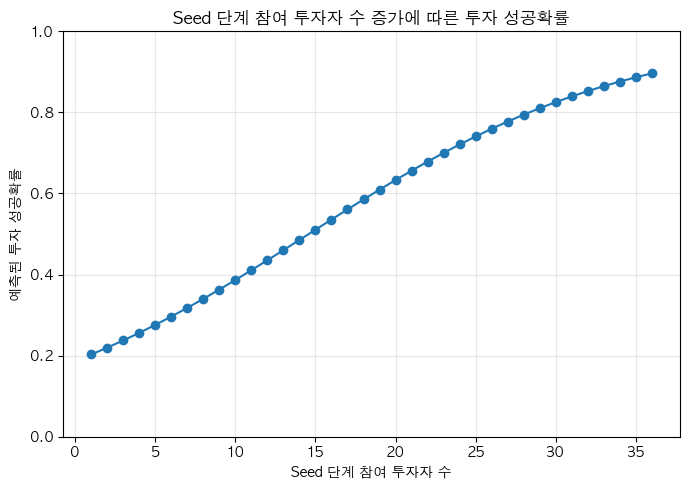

In [ ]:
# #############################################################
# 변경자: 수아
# 변경일자: 25.12.19
# 변경 내용:
# 1. VC 특성에 따른 투자 성공확률 분석 (vc_invest_scs)
#   1-1) seed 단계 참여 투자자 수가 많을수록 투자 성공확률이 높다.
# 검정 방법: 로지스틱 회귀
# #############################################################

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ============================================================
# 가설 설정
# ============================================================
print("\n" + "="*80)
print("가설검정 4-4: Seed 단계 참여 투자자 수 증가에 따른 투자 성공률 분석")
print("="*80)

print("H₀: seed 단계 참여 투자자 수는 투자 성공률에 영향을 미치지 않는다.")
print("H₁: seed 단계 참여 투자자 수가 많을수록 투자 성공확률이 증가한다.")
print("유의수준: α = 0.05")
print("검정 방법: 로지스틱 회귀")

# ============================================================
# 1단계: 데이터 준비 (seed 단계만 필터링)
# ============================================================
df_seed = vc_invest_scs[vc_invest_scs['cat_fr_type'] == 'seed'].copy()

# 필요한 컬럼만 사용
df_model = df_seed[['participants', 'success_flag']].dropna()

print("\n[데이터 요약]")
print("-"*60)
print("표본 수:", len(df_model))
print("success_flag 분포:")
print(df_model['success_flag'].value_counts())

# ============================================================
# 2단계: 데이터 구조 검증 (로지스틱 회귀 가능 여부)
# ============================================================
if df_model['success_flag'].nunique() < 2:
    print("\n❌ 로지스틱 회귀 수행 불가")
    print("-"*60)
    print("사유: seed 단계 데이터에서 투자 성공 여부가 단일 범주로만 관측됨")
    print("→ 초기 투자 단계 특성상 성공/실패가 아직 분화되지 않은 것으로 해석")
    print("→ 본 가설은 데이터 제약으로 인해 통계적 검정이 불가능함")
    
else:
    # ============================================================
    # 3단계: 로지스틱 회귀 수행
    # ============================================================
    X = df_model[['participants']]
    y = df_model['success_flag']

    # 상수항 추가
    X = sm.add_constant(X)

    logit_model = sm.Logit(y, X)
    result = logit_model.fit()

    print("\n[로지스틱 회귀 결과]")
    print("-"*60)
    print(result.summary())

    # ============================================================
    # 4단계: 오즈비(Odds Ratio) 계산
    # ============================================================
    odds_ratios = np.exp(result.params)

    or_df = pd.DataFrame({
        'Coefficient': result.params,
        'Odds Ratio': odds_ratios,
        'p-value': result.pvalues
    })

    print("\n[오즈비(Odds Ratio) 해석 테이블]")
    print("-"*60)
    print(or_df)

    # ============================================================
    # 5단계: 성공확률 시각화
    # ============================================================
    participants_range = np.arange(
        df_model['participants'].min(),
        df_model['participants'].max() + 1
    )

    X_pred = sm.add_constant(participants_range)
    y_pred = result.predict(X_pred)

    plt.figure(figsize=(7, 5))
    plt.plot(participants_range, y_pred, marker='o')
    plt.xlabel('Seed 단계 참여 투자자 수')
    plt.ylabel('예측된 투자 성공확률')
    plt.title('Seed 단계 참여 투자자 수 증가에 따른 투자 성공확률')
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


### VC의 동일 스타트업 재투자 비율과 투자 성공율


가설검정 4-5: VC 동일 스타트업 재투자율과 투자 성공확률 분석
H₀: VC의 동일 스타트업 재투자율은 투자 성공확률에 영향을 미치지 않는다.
H₁: VC의 동일 스타트업 재투자율이 높을수록 투자 성공확률이 증가한다.
유의수준: α = 0.05
검정 방법: 로지스틱 회귀

[데이터 요약]
------------------------------------------------------------
표본 수: 45777
success_flag 분포:
success_flag
0    31088
1    14689
Name: count, dtype: int64

컬럼 dtype 확인:
reinvest_rate    float64
success_flag       int64
dtype: object

[로지스틱 회귀 결과]
------------------------------------------------------------
                           Logit Regression Results                           
Dep. Variable:           success_flag   No. Observations:                45777
Model:                          Logit   Df Residuals:                    45775
Method:                           MLE   Df Model:                            1
Date:                Thu, 25 Dec 2025   Pseudo R-squ.:                 0.01623
Time:                        23:28:44   Log-Likelihood:                -28260.
converged:                       True   LL-Null:         

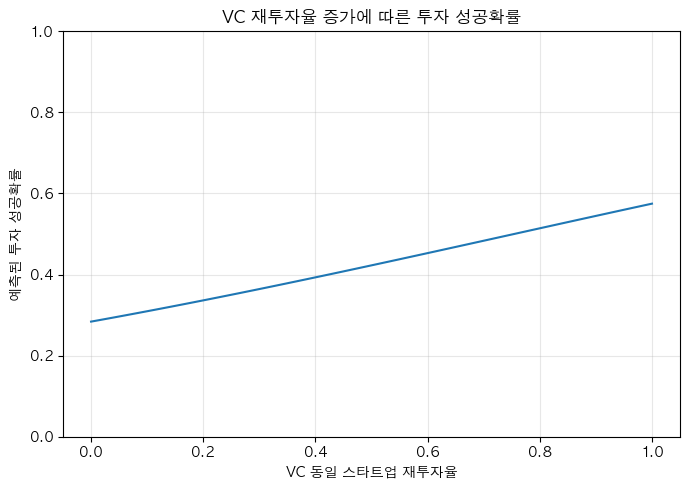

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ============================================================
# 4-5) VC의 동일 스타트업 재투자 비율과 투자 성공률
# ============================================================
# H0: VC 재투자율과 투자 성공률은 독립적이다.
# H1: VC 재투자율이 높을수록 투자 성공확률이 증가한다.
# 검정 방법: 로지스틱 회귀
# ============================================================

print("\n" + "="*80)
print("가설검정 4-5: VC 동일 스타트업 재투자율과 투자 성공확률 분석")
print("="*80)
print("H₀: VC의 동일 스타트업 재투자율은 투자 성공확률에 영향을 미치지 않는다.")
print("H₁: VC의 동일 스타트업 재투자율이 높을수록 투자 성공확률이 증가한다.")
print("유의수준: α = 0.05")
print("검정 방법: 로지스틱 회귀")

# ============================================================
# 1단계: VC–스타트업 단위 재투자율 계산
# ============================================================
reinvest_rate_df = (
    vc_invest_scs
    .groupby(['investor_cfp_id', 'objects_cfpr_id'])
    .agg(
        total_investments=('funding_round_id', 'count'),
        reinvest_count=('reinvest_flag', 'sum')
    )
    .assign(reinvest_rate=lambda x: x['reinvest_count'] / x['total_investments'])
    .reset_index()
)

# ============================================================
# 2단계: 스타트업 단위 성공 여부 결합
# ============================================================
startup_success = (
    vc_invest_scs[['objects_cfpr_id', 'success_flag']]
    .drop_duplicates(subset='objects_cfpr_id')
)

df_model = (
    reinvest_rate_df
    .merge(startup_success, on='objects_cfpr_id', how='left')
)

# ============================================================
# 3단계: 🔥 로지스틱 회귀용 데이터 정제 (핵심)
# ============================================================
df_model = df_model.copy()

# 숫자형 강제 변환
df_model['reinvest_rate'] = pd.to_numeric(
    df_model['reinvest_rate'], errors='coerce'
)
df_model['success_flag'] = pd.to_numeric(
    df_model['success_flag'], errors='coerce'
)

# 무한값 → NaN
df_model = df_model.replace([np.inf, -np.inf], np.nan)

# 결측 제거
df_model = df_model.dropna(subset=['reinvest_rate', 'success_flag'])

# 성공 플래그를 int(0/1)로 고정
df_model['success_flag'] = df_model['success_flag'].astype(int)

print("\n[데이터 요약]")
print("-"*60)
print("표본 수:", len(df_model))
print("success_flag 분포:")
print(df_model['success_flag'].value_counts())
print("\n컬럼 dtype 확인:")
print(df_model[['reinvest_rate', 'success_flag']].dtypes)

# ============================================================
# 4단계: 데이터 구조 검증
# ============================================================
if df_model['success_flag'].nunique() < 2:
    print("\n❌ 로지스틱 회귀 수행 불가")
    print("-"*60)
    print("사유: 투자 성공 여부가 단일 범주로만 관측됨")
    print("→ 데이터 제약으로 인해 본 가설은 통계적 검정이 불가능함")

else:
    # ============================================================
    # 5단계: 로지스틱 회귀 수행
    # ============================================================
    X = df_model[['reinvest_rate']]
    y = df_model['success_flag']

    # 상수항 추가
    X = sm.add_constant(X)

    logit_model = sm.Logit(y, X)
    result = logit_model.fit(disp=False)

    print("\n[로지스틱 회귀 결과]")
    print("-"*60)
    print(result.summary())

    # ============================================================
    # 6단계: 오즈비(Odds Ratio) 계산
    # ============================================================
    odds_ratios = np.exp(result.params)

    or_df = pd.DataFrame({
        'Coefficient': result.params,
        'Odds Ratio': odds_ratios,
        'p-value': result.pvalues
    })

    print("\n[오즈비(Odds Ratio) 해석 테이블]")
    print("-"*60)
    print(or_df)

    # ============================================================
    # 7단계: 재투자율에 따른 성공확률 시각화
    # ============================================================
    rate_range = np.linspace(0, 1, 50)
    X_pred = sm.add_constant(rate_range)
    y_pred = result.predict(X_pred)

    plt.figure(figsize=(7, 5))
    plt.plot(rate_range, y_pred)
    plt.xlabel('VC 동일 스타트업 재투자율')
    plt.ylabel('예측된 투자 성공확률')
    plt.title('VC 재투자율 증가에 따른 투자 성공확률')
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


### VC의 투자 빈도가 높은 산업이 투자 성공률이 높다

In [ ]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# ============================================================
# 0. 필수 컬럼 검증
# ============================================================
required_cols = [
    'investor_cfp_id',
    'objects_cfpr_id',
    'funding_round_id',
    'success_flag',
    'participants',
    'cat_fr_type',
    'cat_obj_overview',
    'reinvest_flag'
]

missing = [c for c in required_cols if c not in vc_invest_scs.columns]
if missing:
    raise ValueError(f"❌ vc_invest_scs에 필요한 컬럼 없음: {missing}")

# ============================================================
# 1. VC–스타트업 단위 재투자율 생성
# ============================================================
reinvest_rate_df = (
    vc_invest_scs
    .groupby(['investor_cfp_id', 'objects_cfpr_id'])
    .agg(
        total_investments=('funding_round_id', 'count'),
        reinvest_count=('reinvest_flag', 'sum')
    )
    .assign(reinvest_rate=lambda x: x['reinvest_count'] / x['total_investments'])
    .reset_index()
)

vc_invest_scs = vc_invest_scs.merge(
    reinvest_rate_df[['investor_cfp_id', 'objects_cfpr_id', 'reinvest_rate']],
    on=['investor_cfp_id', 'objects_cfpr_id'],
    how='left'
)

# ============================================================
# 2. 산업별 VC 투자 빈도 생성
# ============================================================
industry_freq = (
    vc_invest_scs
    .groupby('cat_obj_overview')
    .size()
    .rename('industry_invest_freq')
    .reset_index()
)

vc_invest_scs = vc_invest_scs.merge(
    industry_freq,
    on='cat_obj_overview',
    how='left'
)

# ============================================================
# 3. 로지스틱 회귀용 데이터셋
# ============================================================
model_cols = [
    'success_flag',
    'industry_invest_freq',
    'reinvest_rate',
    'participants',
    'cat_fr_type'
]

df_model = vc_invest_scs[model_cols].copy()

for col in ['industry_invest_freq', 'reinvest_rate', 'participants']:
    df_model[col] = pd.to_numeric(df_model[col], errors='coerce')

df_model['success_flag'] = pd.to_numeric(
    df_model['success_flag'], errors='coerce'
).astype('Int64')

df_model = df_model.dropna()

# ============================================================
# 4. cat_fr_type 더미화
# ============================================================
df_model = pd.get_dummies(
    df_model,
    columns=['cat_fr_type'],
    drop_first=True
)

# ============================================================
# 5. 로지스틱 회귀 수행
# ============================================================
X = df_model.drop(columns='success_flag')
y = df_model['success_flag'].astype(int)

X = X.apply(lambda c: c.astype(int) if c.dtype == 'bool' else c)
X = sm.add_constant(X)

model = sm.Logit(y, X)
result = model.fit(disp=False)

print("\n[로지스틱 회귀 결과 요약]")
print("="*80)
print(result.summary())

# ============================================================
# 6. 오즈비(Odds Ratio) 계산
# ============================================================
odds_ratios = np.exp(result.params)

or_df = pd.DataFrame({
    'Coefficient': result.params,
    'Odds Ratio': odds_ratios,
    'p-value': result.pvalues
})

print("\n[오즈비(Odds Ratio) 테이블]")
print("="*80)
print(or_df)

# ============================================================
# 7. 🔍 결과 해석 자동 출력
# ============================================================
print("\n[결과 해석]")
print("="*80)

alpha = 0.05

def interpret(var, name):
    coef = result.params[var]
    or_val = odds_ratios[var]
    pval = result.pvalues[var]

    if pval < alpha:
        direction = "증가" if coef > 0 else "감소"
        print(
            f"- {name}는 투자 성공 확률에 **통계적으로 유의한 영향**을 미칩니다 "
            f"(p = {pval:.4f}).\n"
            f"  → 해당 변수가 1단위 증가할 때 투자 성공 오즈는 "
            f"{or_val:.2f}배 {direction}합니다."
        )
    else:
        print(
            f"- {name}는 투자 성공 확률에 **통계적으로 유의한 영향이 확인되지 않았습니다** "
            f"(p = {pval:.4f})."
        )

interpret('industry_invest_freq', 'VC의 산업별 투자 빈도')
interpret('reinvest_rate', 'VC의 동일 스타트업 재투자율')
interpret('participants', '투자 라운드 참여자 수')

print("\n※ cat_fr_type 더미 변수들은 기준 라운드 대비 상대적 효과를 의미합니다.")
print("※ 해석은 다른 변수들을 통제한 조건부 효과입니다.")



[로지스틱 회귀 결과 요약]
                           Logit Regression Results                           
Dep. Variable:           success_flag   No. Observations:                61147
Model:                          Logit   Df Residuals:                    61134
Method:                           MLE   Df Model:                           12
Date:                Thu, 25 Dec 2025   Pseudo R-squ.:                 0.07907
Time:                        23:28:45   Log-Likelihood:                -36463.
converged:                       True   LL-Null:                       -39594.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.6790      0.088    -19.102      0.000      -1.851      -1.507
industry_invest_freq          2.204e-06   5.86e-07      3.76

### VC의 규모가 작을수록 투자 성공률이 높다

In [ ]:
vc_invest_scs.columns

Index(['objects_cfpr_id', 'founded_at', 'closed_at', 'description',
       'country_code', 'obj_city_fixed', 'first_investment_at',
       'last_investment_at', 'investment_rounds', 'invested_companies',
       'first_funding_at', 'last_funding_at', 'funding_rounds',
       'funding_total_usd', 'relationships', 'cat_obj_status',
       'obj_category_filled', 'cat_obj_overview', 'obj_state_filled',
       'is_obj_funding_total_usd_private', 'success_flag', 'size_bin',
       'time_to_last_round_months', 'funding_round_id', 'fr_c_id', 'funded_at',
       'funding_round_type', 'funding_round_code', 'raised_amount_usd',
       'pre_money_valuation_usd', 'post_money_valuation_usd', 'participants',
       'is_first_round', 'is_last_round', 'funded_year', 'funded_quarter',
       'cat_fr_type', 'num_fr_type', 'log_participants',
       'is_fr_raised_private', 'prev_round_date', 'round_tempo_days',
       'round_tempo_months', 'acquired_c_id', 'acquisition_id',
       'acquiring_c_id', 'acquir

In [ ]:
# #############################################################
# 변경자: 수아
# 변경일자: 25.12.19
# 변경 내용:
# 1. VC 특성에 따른 투자 성공확률 분석 (vc_invest_scs)
#   4-7) VC의 규모 작을수록 투자 성공률이 높다.
# 검정 방법: 이항 로지스틱
# #############################################################

# ============================================================
# 가설 설정
# ============================================================
print("\n" + "="*80)
print("가설검정 4-7: VC 기업의 규모와 투자 성공률 분석")
print("="*80)

print("H₀: VC 기업의 규모는 투자 성공률에 영향을 미치지 않는다.")
print("H₁: VC 기업의 규모는 투자 성공률에 영향을 준다.")
print("유의수준: α = 0.05")
print("검정 방법: 이항 로지스틱 회귀(VC 단위)")
print("종속변수: VC의 투자 성공률")
print("독립변수: vc 기업의 직원 수(relationships_vc)")

# ============================================================
# 1단계: VC별 성공 투자 건수 (스타트업 단위)
# ============================================================

success_count_df = (
    vc_invest_scs[vc_invest_scs['success_flag'] == 1]
    .groupby('investor_cfp_id')['fr_c_id']
    .nunique()
    .rename('success_count')
    .reset_index()
)

# ============================================================
# 2단계: VC별 전체 투자 건수
# ============================================================

total_invest_df = (
    vc_invest_scs
    .groupby('investor_cfp_id')
    .size()
    .rename('invested_companies_vc')
    .reset_index()
)

# ============================================================
# 3단계: VC 직원 수 (relationships_vc)
# ============================================================

vc_employee_df = (
    vc_invest_scs
    .groupby('investor_cfp_id')['relationships_vc']
    .max()
    .reset_index()
)

# ============================================================
# 4단계: VC 단위 데이터셋 생성
# ============================================================

vc_level_df = (
    total_invest_df
    .merge(success_count_df, on='investor_cfp_id', how='left')
    .merge(vc_employee_df, on='investor_cfp_id', how='left')
)

vc_level_df['success_count'] = vc_level_df['success_count'].fillna(0)

# ============================================================
# 5단계: 데이터 정제 (매우 중요)
# ============================================================

# 직원 수 결측/0 제거
vc_level_df = vc_level_df.dropna(subset=['relationships_vc'])
vc_level_df = vc_level_df[vc_level_df['relationships_vc'] > 0]

# 성공 > 전체 투자 오류 제거
vc_level_df = vc_level_df[
    vc_level_df['invested_companies_vc'] >= vc_level_df['success_count']
]

# 로그 변환
vc_level_df['relationships_vc_log'] = np.log1p(vc_level_df['relationships_vc'])

# 실패 건수
vc_level_df['failure_count'] = (
    vc_level_df['invested_companies_vc'] - vc_level_df['success_count']
)

# ============================================================
# 6단계: 이항 로지스틱 회귀 (Binomial GLM)
# ============================================================

y = vc_level_df[['success_count', 'failure_count']]
X = sm.add_constant(vc_level_df[['relationships_vc_log']])

model = sm.GLM(y, X, family=sm.families.Binomial())
result = model.fit()

print(result.summary())

# ============================================================
# 7단계: 오즈비(Odds Ratio) 및 신뢰구간
# ============================================================

params = result.params
conf = result.conf_int()
conf.columns = ['2.5%', '97.5%']

odds_ratio = np.exp(params)
conf_odds = np.exp(conf)

or_table = pd.DataFrame({
    'odds_ratio': odds_ratio,
    'CI_lower': conf_odds['2.5%'],
    'CI_upper': conf_odds['97.5%'],
    'p_value': result.pvalues
})

print("\n[오즈비(Odds Ratio) 테이블]")
display(or_table)

# ============================================================
# 8단계: 결과 해석
# ============================================================

beta = params['relationships_vc_log']
pval = result.pvalues['relationships_vc_log']
or_val = odds_ratio['relationships_vc_log']

print("\n" + "="*70)
print("해석")
print("="*70)

if pval < 0.05:
    direction = "감소" if beta < 0 else "증가"
    print(
        f"VC 기업의 직원 수(로그)는 투자 성공률에 통계적으로 유의한 영향을 미친다. "
        f"직원 수가 증가할수록 투자 성공 오즈는 {direction}하며 "
        f"(OR = {or_val:.3f}, p = {pval:.4f}), "
        f"이는 VC 조직 규모와 투자 성과 간 구조적 관계를 시사한다."
    )
else:
    print(
        f"VC 기업의 직원 수와 투자 성공률 간의 관계는 "
        f"통계적으로 유의하지 않다 (p = {pval:.4f})."
    )


가설검정 4-7: VC 기업의 규모와 투자 성공률 분석
H₀: VC 기업의 규모는 투자 성공률에 영향을 미치지 않는다.
H₁: VC 기업의 규모는 투자 성공률에 영향을 준다.
유의수준: α = 0.05
검정 방법: 이항 로지스틱 회귀(VC 단위)
종속변수: VC의 투자 성공률
독립변수: vc 기업의 직원 수(relationships_vc)
                         Generalized Linear Model Regression Results                          
Dep. Variable:     ['success_count', 'failure_count']   No. Observations:                 3524
Model:                                            GLM   Df Residuals:                     3522
Model Family:                                Binomial   Df Model:                            1
Link Function:                                  Logit   Scale:                          1.0000
Method:                                          IRLS   Log-Likelihood:                -5459.1
Date:                                Thu, 25 Dec 2025   Deviance:                       5651.5
Time:                                        23:36:10   Pearson chi2:                 4.96e+03
No. Iterations:                                 

,odds_ratio,CI_lower,CI_upper,p_value
const,0.294483,0.278649,0.311216,0.000000
relationships_vc_log,1.037706,1.018688,1.057079,0.000088



해석
VC 기업의 직원 수(로그)는 투자 성공률에 통계적으로 유의한 영향을 미친다. 직원 수가 증가할수록 투자 성공 오즈는 증가하며 (OR = 1.038, p = 0.0001), 이는 VC 조직 규모와 투자 성과 간 구조적 관계를 시사한다.


### VC의 직원 구성이 다양할수록 투자 성공률이 높다

In [268]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ============================================================
# 가설 설정
# ============================================================
print("\n" + "="*80)
print("가설검정 4-8: VC 기업의 직원(직무) 다양성과 투자 성공률 분석")
print("="*80)

print("H₀: VC 기업의 직원(직무) 구성 다양성은 투자 성공률에 영향을 미치지 않는다.")
print("H₁: VC 기업의 직원(직무) 구성 다양성이 높을수록 투자 성공률이 높다.")
print("유의수준: α = 0.05")
print("검정 방법: 이항 로지스틱 회귀 (Binomial GLM)")
print("분석 단위: VC 기업 단위")

# ============================================================
# 1단계: VC별 성공 투자 건수 (스타트업 단위)
# ============================================================
success_count_df = (
    vc_invest_scs[vc_invest_scs['success_flag'] == 1]
    .groupby('investor_cfp_id')['fr_c_id']
    .nunique()
    .rename('success_count')
    .reset_index()
)

# ============================================================
# 2단계: VC별 전체 투자 건수
# ============================================================
total_invest_df = (
    vc_invest_scs
    .groupby('investor_cfp_id')
    .size()
    .rename('total_investments')
    .reset_index()
)

# ============================================================
# 3단계: VC별 직원 다양성 정보
# ============================================================
title_diversity_df = (
    vc_invest_scs
    .groupby('investor_cfp_id')['title_diversity_vc']
    .max()   # VC 단위 고정값 → max / first 모두 가능
    .reset_index()
)

# ============================================================
# 4단계: VC 단위 분석 데이터셋 생성
# ============================================================
vc_level_df = (
    total_invest_df
    .merge(success_count_df, on='investor_cfp_id', how='left')
    .merge(title_diversity_df, on='investor_cfp_id', how='left')
)

# 성공 투자 없는 VC는 0 처리
vc_level_df['success_count'] = vc_level_df['success_count'].fillna(0)

# 실패 건수 생성
vc_level_df['failure_count'] = (
    vc_level_df['total_investments'] - vc_level_df['success_count']
)

# 결측 제거 (회귀용)
vc_level_df = vc_level_df.dropna(
    subset=['title_diversity_vc', 'success_count', 'failure_count']
)

print("\n[VC 단위 데이터 요약]")
print(vc_level_df[['total_investments',
                   'success_count',
                   'failure_count',
                   'title_diversity_vc']].describe())

# ============================================================
# 5단계: 이항 로지스틱 회귀 (Binomial GLM)
# ============================================================

# 종속변수: (성공, 실패)
y = vc_level_df[['success_count', 'failure_count']]

# 독립변수: 직원(직무) 다양성
X = sm.add_constant(vc_level_df[['title_diversity_vc']])

model = sm.GLM(
    y,
    X,
    family=sm.families.Binomial()
)

result = model.fit()
print("\n[로지스틱 회귀 결과]")
print(result.summary())

# ============================================================
# 6단계: 오즈비(Odds Ratio) 및 신뢰구간
# ============================================================
params = result.params
conf = result.conf_int()
conf.columns = ['2.5%', '97.5%']

odds_ratio = np.exp(params)
conf_odds = np.exp(conf)

or_table = pd.DataFrame({
    'odds_ratio': odds_ratio,
    'CI_lower': conf_odds['2.5%'],
    'CI_upper': conf_odds['97.5%'],
    'p_value': result.pvalues
})

print("\n[오즈비(Odds Ratio) 테이블]")
print(or_table)

# ============================================================
# 7단계: 결과 해석
# ============================================================
beta = params['title_diversity_vc']
pval = result.pvalues['title_diversity_vc']
or_val = odds_ratio['title_diversity_vc']

print("\n" + "="*70)
print("해석")
print("="*70)

if pval < 0.05:
    print(
        f"VC 기업의 직원(직무) 다양성은 투자 성공률에 통계적으로 유의한 영향을 미친다. "
        f"직무 다양성 지수가 1 단위 증가할 때 투자 성공 오즈는 "
        f"{or_val:.3f}배 증가하며 (p = {pval:.4f}), "
        f"이는 다양한 직무 구성이 투자 의사결정의 질을 향상시킬 가능성을 시사한다."
    )
else:
    print(
        f"VC 기업의 직원(직무) 다양성과 투자 성공률 간의 관계는 "
        f"통계적으로 유의하지 않았다 (p = {pval:.4f})."
    )



가설검정 4-8: VC 기업의 직원(직무) 다양성과 투자 성공률 분석
H₀: VC 기업의 직원(직무) 구성 다양성은 투자 성공률에 영향을 미치지 않는다.
H₁: VC 기업의 직원(직무) 구성 다양성이 높을수록 투자 성공률이 높다.
유의수준: α = 0.05
검정 방법: 이항 로지스틱 회귀 (Binomial GLM)
분석 단위: VC 기업 단위

[VC 단위 데이터 요약]
       total_investments  success_count  failure_count  title_diversity_vc
count        3532.000000    3532.000000    3532.000000         3532.000000
mean           15.061438       3.707248      11.354190            3.031710
std            36.635914      10.365008      26.865335            2.834051
min             1.000000       0.000000       0.000000            0.000000
25%             2.000000       0.000000       1.000000            1.000000
50%             4.000000       1.000000       3.000000            2.000000
75%            14.000000       3.000000      11.000000            4.000000
max           527.000000     218.000000     388.000000           22.000000

[로지스틱 회귀 결과]
                         Generalized Linear Model Regression Results                          
Dep. V

### 투자 라운드별 투자자 수가 많을수록 투자 성공률이 높다

In [269]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

# ============================================================
# 가설검정: 투자 라운드별 참여자 수가 많을수록 성공 확률이 높다
# ============================================================

print("\n" + "="*80)
print("가설검정: 투자 라운드별 참여자 수(participants)와 투자 성공률")
print("="*80)

print("H₀: 투자 라운드 참여자 수는 투자 성공확률에 영향을 미치지 않는다.")
print("H₁: 투자 라운드 참여자 수가 많을수록 투자 성공확률이 증가한다.")
print("검정 방법: 로지스틱 회귀")
print("종속변수: success_flag (0/1)")
print("독립변수: participants")
print("통제변수: 투자 단계(cat_fr_type)")

# ============================================================
# 1단계: 분석용 컬럼 선택
# ============================================================

cols = [
    'success_flag',
    'participants',
    'cat_fr_type'
]

df = vc_invest_scs[cols].copy()

# ============================================================
# 2단계: 결측 제거
# ============================================================

df = df.dropna()

# ============================================================
# 3단계: 투자 단계 더미화
# ============================================================

df = pd.get_dummies(
    df,
    columns=['cat_fr_type'],
    drop_first=True
)

# bool → int (핵심!)
for col in df.columns:
    if df[col].dtype == 'bool':
        df[col] = df[col].astype(int)

# ============================================================
# 4단계: X, y 분리
# ============================================================

y = df['success_flag']
X = df.drop(columns='success_flag')

X = sm.add_constant(X)

# ============================================================
# 5단계: 로지스틱 회귀
# ============================================================

logit_model = sm.Logit(y, X)
result = logit_model.fit()

print("\n[로지스틱 회귀 결과]")
print(result.summary())

# ============================================================
# 6단계: 오즈비(Odds Ratio)
# ============================================================

or_df = pd.DataFrame({
    'coef': result.params,
    'odds_ratio': np.exp(result.params),
    'p_value': result.pvalues
})

print("\n[오즈비 해석 테이블]")
print(or_df)

# ============================================================
# 7단계: 핵심 가설 해석
# ============================================================

beta = result.params['participants']
pval = result.pvalues['participants']
or_val = np.exp(beta)

print("\n" + "="*70)
print("해석")
print("="*70)

if pval < 0.05:
    print(
        f"투자 라운드 참여자 수는 투자 성공확률에 "
        f"통계적으로 유의한 양(+)의 영향을 미친다.\n"
        f"참여자 수가 1명 증가할 때마다 성공 오즈는 "
        f"{or_val:.3f}배 증가한다 (p = {pval:.4f})."
    )
else:
    print(
        f"투자 라운드 참여자 수와 투자 성공확률 간의 관계는 "
        f"통계적으로 유의하지 않다 (p = {pval:.4f})."
    )



가설검정: 투자 라운드별 참여자 수(participants)와 투자 성공률
H₀: 투자 라운드 참여자 수는 투자 성공확률에 영향을 미치지 않는다.
H₁: 투자 라운드 참여자 수가 많을수록 투자 성공확률이 증가한다.
검정 방법: 로지스틱 회귀
종속변수: success_flag (0/1)
독립변수: participants
통제변수: 투자 단계(cat_fr_type)
Optimization terminated successfully.
         Current function value: 0.602543
         Iterations 6

[로지스틱 회귀 결과]
                           Logit Regression Results                           
Dep. Variable:           success_flag   No. Observations:                61147
Model:                          Logit   Df Residuals:                    61136
Method:                           MLE   Df Model:                           10
Date:                Thu, 25 Dec 2025   Pseudo R-squ.:                 0.06947
Time:                        23:36:41   Log-Likelihood:                -36844.
converged:                       True   LL-Null:                       -39594.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std 

In [ ]:
frs.columns

Index(['funding_round_id', 'fr_c_id', 'funded_at', 'funding_round_type',
       'funding_round_code', 'raised_amount_usd', 'pre_money_valuation_usd',
       'post_money_valuation_usd', 'participants', 'is_first_round',
       'is_last_round', 'funded_year', 'funded_quarter', 'cat_fr_type',
       'num_fr_type', 'log_participants', 'is_fr_raised_private'],
      dtype='object')

### 스타트업 특성과 투자 성공률
- 1-8) 투자 라운드별 조달금액 공개 여부는 성공률에 유의한 차이가 있다.

In [277]:
# ============================================================
# 가설 1-8) 투자 라운드 금액 공개율과 스타트업 투자 성공률
# 검정 방법: Fractional Logit Regression (GLM Binomial)
# 분석 단위(grain): 스타트업 (objects_cfpr_id)
# ============================================================

import numpy as np
import pandas as pd
import statsmodels.api as sm

# ============================================================
# 0. 데이터 로드
# ============================================================

startup_profile = pd.read_csv('./join_data/startup_profile.csv')

# ============================================================
# 1. success_master 필터링
# - 스타트업만
# - 실제 투자 이벤트만
# ============================================================

cond1 = success_master['objects_cfpr_id'].str.startswith('c:')
cond2 = success_master['funding_round_id'].notna()

success_master_f = success_master[cond1 & cond2].copy()

print("필터링 후 success_master 행 수:", success_master_f.shape[0])

# ============================================================
# 2. startup_profile + success_master 조인
# (funding_round × startup grain, 이후 집계 예정)
# ============================================================

s_prof_sm = startup_profile.merge(
    success_master_f[
        ['objects_cfpr_id', 'success_flag', 'is_fr_raised_private']
    ],
    on='objects_cfpr_id',
    how='left'
)

print("조인 후 테이블 행 수:", s_prof_sm.shape[0])

# ============================================================
# 3. 스타트업별 투자 성공률 계산 (종속변수)
# ============================================================

success_rate_df = (
    s_prof_sm
    .groupby('objects_cfpr_id', as_index=False)['success_flag']
    .mean()
    .rename(columns={'success_flag': 'success_rate'})
)

# ============================================================
# 4. 스타트업별 투자금 공개율 계산 (독립변수)
# - is_fr_raised_private: 1=비공개, 0=공개
# ============================================================

open_rate_df = (
    s_prof_sm
    .groupby('objects_cfpr_id', as_index=False)['is_fr_raised_private']
    .mean()
    .rename(columns={'is_fr_raised_private': 'private_rate'})
)

open_rate_df['open_rate'] = 1 - open_rate_df['private_rate']

# ============================================================
# 5. 스타트업 단위 최종 분석 테이블 생성
# ============================================================

startup_level_df = (
    success_rate_df
    .merge(
        open_rate_df[['objects_cfpr_id', 'open_rate']],
        on='objects_cfpr_id',
        how='inner'
    )
    .dropna(subset=['success_rate', 'open_rate'])
)

print("\n[스타트업 단위 데이터 요약]")
print(startup_level_df.describe())

# ============================================================
# 6. Fractional Logit Regression
# ============================================================

y = startup_level_df['success_rate']
X = sm.add_constant(startup_level_df[['open_rate']])

model = sm.GLM(
    y,
    X,
    family=sm.families.Binomial()
)

result = model.fit()

print("\n" + "="*80)
print("[Fractional Logit 회귀 결과]")
print("="*80)
print(result.summary())

# ============================================================
# 7. 오즈비(Odds Ratio) 및 신뢰구간
# ============================================================

params = result.params
pvals = result.pvalues
conf = result.conf_int()
conf.columns = ['2.5%', '97.5%']

odds_ratio = np.exp(params)
conf_odds = np.exp(conf)

or_table = pd.DataFrame({
    'coef': params,
    'odds_ratio': odds_ratio,
    'CI_lower': conf_odds['2.5%'],
    'CI_upper': conf_odds['97.5%'],
    'p_value': pvals
})

print("\n" + "="*80)
print("[오즈비(Odds Ratio) 테이블]")
print("="*80)
print(or_table)

# ============================================================
# 8. 결과 해석 자동 출력
# ============================================================

beta = params['open_rate']
pval = pvals['open_rate']
or_val = odds_ratio['open_rate']

print("\n" + "="*80)
print("결과 해석")
print("="*80)

if pval < 0.05:
    direction = "증가" if beta > 0 else "감소"
    print(
        f"투자 라운드 금액 공개율은 스타트업의 투자 성공률에 "
        f"통계적으로 유의한 영향을 미친다 (p = {pval:.4f}).\n"
        f"공개율이 증가할수록 스타트업의 투자 성공 오즈는 "
        f"{or_val:.3f}배 {direction}한다."
    )
else:
    print(
        f"투자 라운드 금액 공개율과 스타트업의 투자 성공률 간 관계는 "
        f"통계적으로 유의하지 않았다 (p = {pval:.4f})."
    )


필터링 후 success_master 행 수: 52626
조인 후 테이블 행 수: 215055

[스타트업 단위 데이터 요약]
       success_rate     open_rate
count  31633.000000  31633.000000
mean       0.166851      0.859113
std        0.372849      0.332215
min        0.000000      0.000000
25%        0.000000      1.000000
50%        0.000000      1.000000
75%        0.000000      1.000000
max        1.000000      1.000000

[Fractional Logit 회귀 결과]
                 Generalized Linear Model Regression Results                  
Dep. Variable:           success_rate   No. Observations:                31633
Model:                            GLM   Df Residuals:                    31631
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14219.
Date:                Thu, 25 Dec 2025   Deviance:                       28437.
Time:                        23:56:11   Pear

# 생존분석

### 생존 분석을 위한 테이블 조인

In [278]:
# Load Files

import pandas as pd

# 날짜 컬럼 방지
def read_csv_auto_dates(path):
    # 1) 전체 파일을 먼저 읽기
    temp = pd.read_csv(path, low_memory=False)
    
    # 2) _at 로 끝나는 컬럼 자동 탐지
    date_cols = [col for col in temp.columns if col.endswith('_at')]
    
    # 3) 다시 날짜 컬럼을 datetime 으로 읽기
    return pd.read_csv(path, parse_dates=date_cols, low_memory=False)

# Load Files
startup_profile = read_csv_auto_dates('./join_data/startup_profile.csv')
founder_profile = read_csv_auto_dates('./join_data/invested_founder_master.csv')
success_master = read_csv_auto_dates('./join_data/success_master.csv')

print("="*60)
print("join dataset 로드 완료!")
print("="*60)

join dataset 로드 완료!


In [ ]:
# invested_founder_master 테이블의 birthplace 컬럼 전처리

# 텍스트 정규화
import pandas as pd
import numpy as np
import re

def normalize_text(x):
    if pd.isna(x):
        return np.nan
    x = x.lower()
    x = re.sub(r'\(.*?\)', '', x)      # 괄호 제거
    x = re.sub(r'[^a-z\s]', ' ', x)    # 특수문자 제거
    x = re.sub(r'\s+', ' ', x).strip() # 공백 정리
    return x

founder_profile['birthplace_norm'] = founder_profile['birthplace'].apply(normalize_text)

# 국가명 매핑
country_alias = {
    'usa': 'United States',
    'us': 'United States',
    'united states': 'United States',
    'uk': 'United Kingdom',
    'united kingdom': 'United Kingdom',
    'uae': 'United Arab Emirates',
    'sg': 'Singapore',
    'nz': 'New Zealand',
    'cz': 'Czech Republic',
    'korea': 'South Korea',
    'south korea': 'South Korea',
    'taiwan': 'Taiwan',
    'hong kong': 'Hong Kong',
    'peoples republic of china': 'China',
    'china': 'China',
}

# 도시 -> 국가 매핑
city_to_country = {
    # US
    'san antonio': 'United States',
    'burbank': 'United States',
    'redwood city': 'United States',
    'baton rouge': 'United States',
    'youngstown': 'United States',
    'fullerton': 'United States',
    'hollywood': 'United States',
    'long beach': 'United States',

    # UK
    'london': 'United Kingdom',
    'durham': 'United Kingdom',
    'exeter': 'United Kingdom',
    'preston': 'United Kingdom',
    'slough': 'United Kingdom',
    'kent': 'United Kingdom',
    'epsom': 'United Kingdom',

    # Germany
    'nuremberg': 'Germany',
    'hannover': 'Germany',
    'bonn': 'Germany',
    'essen': 'Germany',
    'bochum': 'Germany',
    'augsburg': 'Germany',
    'aachen': 'Germany',
    'siegen': 'Germany',

    # France
    'angers': 'France',
    'poitiers': 'France',
    'toulon': 'France',

    # Italy
    'verona': 'Italy',
    'naples': 'Italy',
    'empoli': 'Italy',
    'fiesole': 'Italy',
    'ravenna': 'Italy',

    # Spain
    'oviedo': 'Spain',

    # Japan
    'tokyo': 'Japan',

    # India
    'agra': 'India',
    'jodhpur': 'India',
    'kolkatta': 'India',
    'guntur': 'India',
    'theni': 'India',
    'sirsā': 'India',

    # Netherlands / Belgium
    'breda': 'Netherlands',
    'antwerp': 'Belgium',
    'brugge': 'Belgium',
}

# 최종 매핑 함수
def map_to_country(x):
    if pd.isna(x):
        return np.nan

    # 1) 국가 alias 우선
    if x in country_alias:
        return country_alias[x]

    # 2) 도시 매핑
    if x in city_to_country:
        return city_to_country[x]

    # 3) 명확한 국가명 패턴
    if len(x.split()) <= 3 and x.title() in country_alias.values():
        return x.title()

    # 4) 그 외 → NaN
    return np.nan

founder_profile['birthplace_country'] = (
    founder_profile['birthplace_norm']
    .apply(map_to_country)
)

In [281]:
founder_profile['birthplace_country'].value_counts()

birthplace_country
United States     1245
United Kingdom      41
China                8
Taiwan               7
Hong Kong            5
Singapore            5
New Zealand          5
South Korea          5
Germany              4
Czech Republic       3
Belgium              2
Italy                2
France               1
Netherlands          1
Name: count, dtype: int64

In [282]:
founder_profile['subject'].unique()

array(['Computer Science / Software', nan, 'Marketing / Communications',
       'Arts / Humanities', 'Finance / Accounting',
       'Business Administration', 'Physics / Chemistry', 'Law',
       'Psychology / Sociology',
       'Political Science / International Relations',
       'Medicine / Clinical Science', 'Biology / Life Science',
       'Others / Unknown', 'Design / Architecture',
       'AI / Data / Robotics', 'Mechanical / Industrial Engineering',
       'Biotechnology / Pharmaceutical', 'Economics',
       'Public Policy / Administration', 'Education',
       'Electrical / Electronic Engineering', 'General Studies'],
      dtype=object)

In [283]:
# Founder_profile에 STEM 비율 플래그 생성
# STEM 여부 플래그 컬럼 생성: STEM = 1, notSTEM + NaN = 0
stem_subjects = [
    'Computer Science / Software',
    'AI / Data / Robotics',
    'Physics / Chemistry',
    'Biology / Life Science',
    'Medicine / Clinical Science',
    'Biotechnology / Pharmaceutical',
    'Mechanical / Industrial Engineering',
    'Electrical / Electronic Engineering'
]

founder_profile['is_stem'] = founder_profile['subject'].isin(stem_subjects).astype(int)

# 스타트업별 STEM 비율 → founder_profile에 바로 추가
founder_profile['subject_stem'] = (
    founder_profile
        .groupby('rel_cf_id')['is_stem']
        .transform('mean').round(2)
)

# 확인
founder_profile['subject_stem'].describe()


count    14747.000000
mean         0.222660
std          0.341285
min          0.000000
25%          0.000000
50%          0.000000
75%          0.500000
max          1.000000
Name: subject_stem, dtype: float64

In [284]:
# 스타트업별 창업자 수(n_founders) 컬럼 생성
founder_profile['n_founders'] = (
    founder_profile
        .groupby('rel_cf_id')['rel_cf_id']
        .transform('size')
)

In [285]:
import unicodedata
import re

# 명문대학 여부 플래그 생성
univ_rank = pd.read_csv("./data/top100_univ.csv")
# 학교명 정규화 함수
def norm_school(x: str) -> str:
    if pd.isna(x):
        return ""
    x = str(x).strip().lower()

    # 유니코드 정규화 (예: é, ü 등 처리 일관화)
    x = unicodedata.normalize("NFKC", x)

    # 괄호 내용 제거: "Harvard University (HBS)" -> "Harvard University"
    x = re.sub(r"\([^)]*\)", "", x)

    # &, / 등은 공백으로 치환
    x = re.sub(r"[&/]", " ", x)

    # 영숫자/공백 외 제거
    x = re.sub(r"[^a-z0-9\s]", " ", x)

    # 중복 공백 정리
    x = re.sub(r"\s+", " ", x).strip()
    return x

# top100 대학명 집합(set) 
qs_univ_set = set(univ_rank["university"].map(norm_school))
print("QS top100 unique normalized names:", len(qs_univ_set))

# 학교명 매핑
founder_profile["institution_norm"] = founder_profile["institution"].map(norm_school)

# top100 플래그 생성
founder_profile["is_univ_top100"] = founder_profile["institution_norm"].isin(qs_univ_set).astype(int)

# 결과 확인
print(founder_profile["is_univ_top100"].value_counts(dropna=False))

QS top100 unique normalized names: 100
is_univ_top100
0    12899
1     1848
Name: count, dtype: int64


In [286]:
founder_profile[founder_profile['birthplace'].notna()]

,rel_p_id,rel_cf_id,n_founding,is_past,sequence,birthplace,degree_level,subject,institution,graduated_at,birthplace_norm,birthplace_country,is_stem,subject_stem,n_founders,institution_norm,is_univ_top100
10,p:100124,c:81645,3,0,3,United States,0.0,Computer Science / Software,universiti of florence,1996-01-01,united states,United States,1,0.50,2,universiti of florence,0
14,p:10018,c:4899,1,1,1,United States,NaN,NaN,NaN,NaN,united states,United States,0,0.00,2,,0
15,p:100185,c:75520,1,0,2,United States,3.0,Computer Science / Software,NaN,2011-01-01,united states,United States,1,0.33,3,,0
22,p:100256,c:75520,1,0,1,United States,NaN,NaN,NaN,NaN,united states,United States,0,0.33,3,,0
32,p:100372,c:149254,1,0,2,Japan,2.0,Arts / Humanities,yale university,1997-01-01,japan,NaN,0,0.00,4,yale university,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14724,p:99588,c:78993,1,1,2,United States,NaN,NaN,NaN,NaN,united states,United States,0,0.00,1,,0
14726,p:99625,c:151768,1,0,1,United States,3.0,NaN,missouri university,2011-01-01,united states,United States,0,0.00,2,missouri university,0
14729,p:99761,c:81381,1,0,1,United States,NaN,NaN,NaN,NaN,united states,United States,0,0.00,1,,0
14734,p:99835,c:196633,2,0,7,United States,2.0,Computer Science / Software,harvard university,1998-01-01,united states,United States,1,0.50,2,harvard university,1


In [287]:
founder_profile['birthplace_country'].value_counts()

birthplace_country
United States     1245
United Kingdom      41
China                8
Taiwan               7
Hong Kong            5
Singapore            5
New Zealand          5
South Korea          5
Germany              4
Czech Republic       3
Belgium              2
Italy                2
France               1
Netherlands          1
Name: count, dtype: int64

In [288]:
# 미국 출생 여부 플래그 생성
# 1. 미국 출생 여부 플래그
founder_profile['is_us_born'] = (
    founder_profile['birthplace_country'] == 'United States'
).astype(int)

# 2. 스타트업별 미국 출생 창업자 비율 → founder_profile에 바로 추가
founder_profile['us_born_ratio'] = (
    founder_profile
        .groupby('rel_cf_id')['is_us_born']
        .transform('mean')
)

In [289]:
# =========================================
# STEP 0. 필요한 컬럼 가정
# rel_cf_id, rel_p_id, sequence, is_past
# n_founding, degree_level, subject_stem
# n_founders, is_univ_top100, us_born_ratio
# =========================================


# =========================================
# STEP 1. 스타트업별 대표 창업자 선택
# - sequence 가장 작은 창업자 먼저 선택
# - 그중에서 is_past == 0 인 경우만 유지
# =========================================

rep_founder = (
    founder_profile
    .sort_values(['rel_cf_id', 'sequence'])
    .groupby('rel_cf_id', as_index=False)
    .head(1)
    .query('is_past == 0')
    [['rel_cf_id', 'rel_p_id']]
)


# =========================================
# STEP 2. 창업자 특성 집계 (startup-level)
# - 모든 창업자 기준 집계
# =========================================

founder_agg = (
    founder_profile
    .groupby('rel_cf_id', as_index=False)
    .agg(
        n_founding_max   = ('n_founding', 'max'),
        degree_max      = ('degree_level', 'max'),
        stem_ratio      = ('subject_stem', 'mean'),
        co_founders     = ('n_founders', 'mean'),
        top_university  = ('is_univ_top100', 'mean'),
        us_born_ratio   = ('us_born_ratio', 'mean')
    )
)


# =========================================
# STEP 3. 대표 창업자 + 집계 결과 결합
# - 최종 grain: rel_cf_id 1행
# =========================================

founder_profile_per_company = (
    rep_founder
    .merge(founder_agg, on='rel_cf_id', how='left')
)


# =====================================================
# STEP 4. 검증 (중요)
# =====================================================

print("최종 shape:", founder_profile_per_company.shape)
print("rel_cf_id 중복 수:",
      founder_profile_per_company['rel_cf_id'].duplicated().sum())

founder_profile_per_company.head()


최종 shape: (6516, 8)
rel_cf_id 중복 수: 0


,rel_cf_id,rel_p_id,n_founding_max,degree_max,stem_ratio,co_founders,top_university,us_born_ratio
0,c:1,p:59304,2,2.0,1.0,2.0,0.0,0.0
1,c:10014,p:16925,3,NaN,0.0,1.0,0.0,0.0
2,c:10015,p:16930,3,0.0,1.0,1.0,1.0,0.0
3,c:10018,p:17332,1,NaN,0.0,1.0,0.0,0.0
4,c:100189,p:23613,1,NaN,0.0,1.0,0.0,0.0


In [ ]:
# 스타트업 단위로 집계
sm_agg = (
    success_master
    .groupby('objects_cfpr_id', as_index=False)
    .agg(
        # =========================
        # 생존 / 성공 관련
        # =========================
        success_flag=('success_flag', 'max'),

        # =========================
        # 펀딩 구조
        # =========================
        total_participants=('participants', 'max'),

        # =========================
        # 시간 변수
        # =========================
        time_to_last_round_months=('time_to_last_round_months', 'max'),
        round_tempo_months=('round_tempo_months', 'mean'),

        # =========================
        # Exit 이벤트
        # =========================
        has_acquisition=('acquisition_id', lambda x: x.notna().any()),
        acquired_at=('acquired_at', 'min'),

        has_ipo=('ipo_id', lambda x: x.notna().any()),
        first_public_at=('first_public_at', 'min'),

        # =========================
        # 🔑 금액 공개율 관련
        # =========================
        private_rate=('is_fr_raised_private', 'mean'),
        n_offices = ('n_offices', 'mean')
    )
)

# bool → int (모델용)
sm_agg['has_acquisition'] = sm_agg['has_acquisition'].astype(int)
sm_agg['has_ipo'] = sm_agg['has_ipo'].astype(int)

# 공개율 = 1 - 비공개율
sm_agg['open_rate'] = 1 - sm_agg['private_rate']


In [291]:
# =====================================
# title_diversity 생성 (회사 단위)
# =====================================

title_diversity_df = (
    rel
    .dropna(subset=['cat_rel_title'])   # 직함 없는 관계 제외
    .groupby('rel_cf_id')['cat_rel_title']
    .nunique()
    .reset_index()
    .rename(columns={'cat_rel_title': 'title_diversity'})
)

print(title_diversity_df.head())
print("title_diversity rows:", title_diversity_df.shape)


  rel_cf_id  title_diversity
0       c:1                7
1      c:10                4
2     c:100                7
3    c:1000                1
4   c:10002                2
title_diversity rows: (133986, 2)


In [292]:
# 생존분석을 위한 테이블 조인
# startup 필요한 컬럼 선택
cols_su = ['objects_cfpr_id', 'founded_at', 'closed_at',
       'country_code', 'obj_state_filled', 'obj_city_fixed',
       'first_funding_at', 'last_funding_at', 'funding_rounds',
       'funding_total_usd', 'relationships', 'cat_obj_status',
       'obj_category_filled', 'cat_obj_overview', 
       'is_obj_funding_total_usd_private', 'offices_c_id',
       'office_city', 'rel_cf_id', 'relationship_growth']
su_sel = startup_profile[cols_su].copy()


# founder_profile 필요한 컬럼 선택
col_fm = ['rel_cf_id', 'rel_p_id', 'n_founding_max', 'degree_max', 'stem_ratio',
       'co_founders', 'top_university', 'us_born_ratio']

fd_sel = founder_profile_per_company[col_fm].copy()


# success_master 필요한 컬럼 선택
cols_sv = ['objects_cfpr_id', 'success_flag', 'total_participants', 
           'time_to_last_round_months', 'round_tempo_months', 'has_acquisition', 
           'acquired_at', 'has_ipo', 'first_public_at', 'open_rate', 'n_offices']
sm_sel = sm_agg[cols_sv].copy()


# merge
surv = (su_sel
               .merge(fd_sel, left_on='objects_cfpr_id', right_on='rel_cf_id', how='left')
               .merge(sm_sel, on='objects_cfpr_id', how='left')
               .merge(title_diversity_df, left_on='objects_cfpr_id', right_on='rel_cf_id', how='left')
               )


# 중복 키 정리
surv = surv.drop(columns=['rel_cf_id_y'], errors='ignore') \
           .rename(columns={'rel_cf_id_x': 'rel_cf_id'})

# 관계 정보 없는 회사 → 직함 다양성 0
surv['title_diversity'] = surv['title_diversity'].fillna(0)

# 행 수 확인
print(f"조인 전 행수: {startup_profile.shape}")
print(f"조인 후 행수: {surv.shape}")

조인 전 행수: (194151, 25)
조인 후 행수: (194151, 38)


In [293]:
# founded_at 결측 플래그 생성
miss_cols = ['founded_at', 'first_funding_at', 'acquired_at', 'first_public_at']

for col in miss_cols:
    surv[f'is_{col}_missing'] = surv[col].isna().astype(int)

In [294]:
surv

,objects_cfpr_id,founded_at,closed_at,country_code,obj_state_filled,obj_city_fixed,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,relationships,cat_obj_status,obj_category_filled,cat_obj_overview,is_obj_funding_total_usd_private,offices_c_id,office_city,rel_cf_id,relationship_growth,rel_p_id,n_founding_max,degree_max,stem_ratio,co_founders,top_university,us_born_ratio,success_flag,total_participants,time_to_last_round_months,round_tempo_months,has_acquisition,acquired_at,has_ipo,first_public_at,open_rate,n_offices,rel_cf_id,title_diversity,is_founded_at_missing,is_first_funding_at_missing,is_acquired_at_missing,is_first_public_at_missing
0,c:1,2005-10-17,NaT,USA,WA,seattle,2005-10-01,2008-05-19,3.0,39750000.0,17,operating,web,Software & Technology,0,c:1,Seattle,c:1,7,p:59304,2.0,2.0,1.0,2.0,0.0,0.0,1,4.0,32.0,NaN,0,NaT,0,NaT,1.0,2.0,c:1,7.0,0,0,1,1
1,c:10,NaT,NaT,USA,CA,culver city,NaT,NaT,NaN,NaN,6,acquired,games_video,Software & Technology,1,c:10,Culver City,c:10,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1,2007-05-30,0,NaT,NaN,1.0,c:10,4.0,1,1,0,1
2,c:100,NaT,NaT,USA,CA,san mateo,NaT,NaT,NaN,NaN,12,acquired,games_video,Software & Technology,1,c:100,San Mateo,c:100,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1,2005-05-29,0,NaT,NaN,1.0,c:100,7.0,1,1,0,1
3,c:10000,2008-07-26,NaT,NaN,NaN,NaN,NaT,NaT,0.0,0.0,0,operating,network_hosting,Software & Technology,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaT,0,NaT,NaN,NaN,NaN,0.0,0,1,1,1
4,c:10001,2008-07-26,NaT,NaN,NaN,NaN,NaT,NaT,0.0,0.0,0,operating,games_video,Software & Technology,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaT,0,NaT,NaN,NaN,NaN,0.0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194146,c:99940,2007-01-01,NaT,USA,CA,san francisco,NaT,NaT,0.0,0.0,5,operating,ecommerce,Software & Technology,0,c:99940,San Francisco,c:99940,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaT,0,NaT,NaN,1.0,c:99940,4.0,0,1,1,1
194147,c:9995,2007-11-01,NaT,USA,CA,san jose,2008-08-25,2008-08-25,1.0,750000.0,14,operating,public_relations,Software & Technology,0,c:9995,San Jose,c:9995,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,NaN,NaN,0,NaT,0,NaT,1.0,1.0,c:9995,6.0,0,0,1,1
194148,c:9996,1959-01-01,NaT,USA,VA,falls church,NaT,NaT,0.0,0.0,44,operating,consulting,Software & Technology,0,c:9996,Falls Church,c:9996,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaT,0,NaT,NaN,1.0,c:9996,13.0,0,1,1,1
194149,c:9997,2008-07-01,NaT,USA,CA,los angeles,NaT,NaT,0.0,0.0,1,operating,search,Software & Technology,0,c:9997,Los Angeles,c:9997,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaT,0,NaT,NaN,1.0,c:9997,1.0,0,1,1,1


In [295]:
# 생존 분석을 위한 조인 테이블 csv 저장
surv.to_csv('./join_data/survival_master.csv', index=False)

### 스타트업이 설립부터 첫 투자까지 걸린 시간

- 스타트업이 설립부터 첫 투자까지 걸린 시간 ✅
    - founded_at 결측 플래그, first_funding_at 결측 플래그
- 스타트업이 성공(exit)까지 걸린 시간 (첫투자 → 처음 발생한 ipo & m&a)
    - acquired_at 결측 플래그, first_public_at 결측 플래그

In [296]:
# 설립부터 첫 투자까지 걸린 시간 파생 변수 생성: time_to_first_funding
surv['time_to_first_funding'] = ((surv['first_funding_at'] - surv['founded_at']).dt.days / 30)
surv['time_to_first_funding'] = surv['time_to_first_funding'].round(2)

# 유효하지 않은 값(NaT, 음수)을 NaN으로 변경
cond1 = surv["is_founded_at_missing"]== 0
cond2 = surv["is_first_funding_at_missing"]==0
cond3 = (surv["first_funding_at"] >= surv["founded_at"]) # 마지막 < 첫 번째

mask_valid = (cond1 & cond2 & cond3)

surv.loc[~mask_valid, "time_to_first_funding"] = np.nan
display(surv.loc[mask_valid, ["founded_at", "first_funding_at", "time_to_first_funding"]].head())

,founded_at,first_funding_at,time_to_first_funding
13,2007-10-01,2008-02-26,4.93
18,2008-03-01,2008-09-01,6.13
19,2007-10-01,2008-10-10,12.50
20,2003-01-01,2011-03-08,99.60
24,2006-01-01,2008-08-25,32.23


In [297]:
surv.columns

Index(['objects_cfpr_id', 'founded_at', 'closed_at', 'country_code',
       'obj_state_filled', 'obj_city_fixed', 'first_funding_at',
       'last_funding_at', 'funding_rounds', 'funding_total_usd',
       'relationships', 'cat_obj_status', 'obj_category_filled',
       'cat_obj_overview', 'is_obj_funding_total_usd_private', 'offices_c_id',
       'office_city', 'rel_cf_id', 'relationship_growth', 'rel_p_id',
       'n_founding_max', 'degree_max', 'stem_ratio', 'co_founders',
       'top_university', 'us_born_ratio', 'success_flag', 'total_participants',
       'time_to_last_round_months', 'round_tempo_months', 'has_acquisition',
       'acquired_at', 'has_ipo', 'first_public_at', 'open_rate', 'n_offices',
       'rel_cf_id', 'title_diversity', 'is_founded_at_missing',
       'is_first_funding_at_missing', 'is_acquired_at_missing',
       'is_first_public_at_missing', 'time_to_first_funding'],
      dtype='object')

In [298]:
# 첫 투자부터 ipo까지 걸린 시간 파생 변수 생성: time_to_ipo
surv['time_to_ipo'] = ((surv['first_public_at'] - surv['first_funding_at']).dt.days / 30)
surv['time_to_ipo'] = surv['time_to_ipo'].round(2)

# 유효하지 않은 값(NaT, 음수)을 NaN으로 변경
cond1 = surv["is_first_public_at_missing"]== 0
cond2 = surv["is_first_funding_at_missing"]==0
cond3 = (surv["first_public_at"] >= surv["first_funding_at"])

mask_valid = (cond1 & cond2 & cond3)

surv.loc[~mask_valid, "time_to_ipo"] = np.nan
display(surv.loc[mask_valid, ["first_funding_at", "first_public_at", "time_to_ipo"]].head())

,first_funding_at,first_public_at,time_to_ipo
1394,2007-01-01,2013-11-14,83.63
1402,1999-09-01,2009-11-13,124.20
1813,2007-12-01,2013-11-06,72.23
2188,2007-01-01,2011-11-07,59.03
2921,2007-07-01,2013-11-07,77.37


In [299]:
# 첫 투자부터 M&A까지 걸린 시간 파생 변수 생성: time_to_acq
surv['time_to_acq'] = ((surv['acquired_at'] - surv['first_funding_at']).dt.days / 30)
surv['time_to_acq'] = surv['time_to_acq'].round(2)

# 유효하지 않은 값(NaT, 음수)을 NaN으로 변경
cond1 = surv["is_first_funding_at_missing"]== 0
cond2 = surv["is_acquired_at_missing"]==0
cond3 = (surv["acquired_at"] >= surv["first_funding_at"]) 

mask_valid = (cond1 & cond2 & cond3)

surv.loc[~mask_valid, "time_to_acq"] = np.nan
display(surv.loc[mask_valid, ["first_funding_at", "acquired_at", "time_to_acq"]].head())

,first_funding_at,acquired_at,time_to_acq
13,2008-02-26,2009-08-10,17.7
18,2008-09-01,2010-09-30,25.3
64,2005-03-01,2013-08-13,102.9
79,2007-07-01,2008-05-08,10.4
164,2011-07-01,2013-09-18,27.0


In [300]:
# 이벤트 컬럼 생성
surv['first_funding_event'] = (
    1 - surv['is_first_funding_at_missing']
)

surv['ipo_event'] = (
    1 - surv['is_first_public_at_missing']
)

surv['acq_event'] = (
    1 - surv['is_acquired_at_missing']
)


In [301]:
surv

,objects_cfpr_id,founded_at,closed_at,country_code,obj_state_filled,obj_city_fixed,first_funding_at,last_funding_at,funding_rounds,funding_total_usd,relationships,cat_obj_status,obj_category_filled,cat_obj_overview,is_obj_funding_total_usd_private,offices_c_id,office_city,rel_cf_id,relationship_growth,rel_p_id,n_founding_max,degree_max,stem_ratio,co_founders,top_university,us_born_ratio,success_flag,total_participants,time_to_last_round_months,round_tempo_months,has_acquisition,acquired_at,has_ipo,first_public_at,open_rate,n_offices,rel_cf_id,title_diversity,is_founded_at_missing,is_first_funding_at_missing,is_acquired_at_missing,is_first_public_at_missing,time_to_first_funding,time_to_ipo,time_to_acq,first_funding_event,ipo_event,acq_event
0,c:1,2005-10-17,NaT,USA,WA,seattle,2005-10-01,2008-05-19,3.0,39750000.0,17,operating,web,Software & Technology,0,c:1,Seattle,c:1,7,p:59304,2.0,2.0,1.0,2.0,0.0,0.0,1,4.0,32.0,NaN,0,NaT,0,NaT,1.0,2.0,c:1,7.0,0,0,1,1,NaN,NaN,NaN,1,0,0
1,c:10,NaT,NaT,USA,CA,culver city,NaT,NaT,NaN,NaN,6,acquired,games_video,Software & Technology,1,c:10,Culver City,c:10,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1,2007-05-30,0,NaT,NaN,1.0,c:10,4.0,1,1,0,1,NaN,NaN,NaN,0,0,1
2,c:100,NaT,NaT,USA,CA,san mateo,NaT,NaT,NaN,NaN,12,acquired,games_video,Software & Technology,1,c:100,San Mateo,c:100,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,1,2005-05-29,0,NaT,NaN,1.0,c:100,7.0,1,1,0,1,NaN,NaN,NaN,0,0,1
3,c:10000,2008-07-26,NaT,NaN,NaN,NaN,NaT,NaT,0.0,0.0,0,operating,network_hosting,Software & Technology,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaT,0,NaT,NaN,NaN,NaN,0.0,0,1,1,1,NaN,NaN,NaN,0,0,0
4,c:10001,2008-07-26,NaT,NaN,NaN,NaN,NaT,NaT,0.0,0.0,0,operating,games_video,Software & Technology,0,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaT,0,NaT,NaN,NaN,NaN,0.0,0,1,1,1,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194146,c:99940,2007-01-01,NaT,USA,CA,san francisco,NaT,NaT,0.0,0.0,5,operating,ecommerce,Software & Technology,0,c:99940,San Francisco,c:99940,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaT,0,NaT,NaN,1.0,c:99940,4.0,0,1,1,1,NaN,NaN,NaN,0,0,0
194147,c:9995,2007-11-01,NaT,USA,CA,san jose,2008-08-25,2008-08-25,1.0,750000.0,14,operating,public_relations,Software & Technology,0,c:9995,San Jose,c:9995,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0.0,NaN,NaN,0,NaT,0,NaT,1.0,1.0,c:9995,6.0,0,0,1,1,9.93,NaN,NaN,1,0,0
194148,c:9996,1959-01-01,NaT,USA,VA,falls church,NaT,NaT,0.0,0.0,44,operating,consulting,Software & Technology,0,c:9996,Falls Church,c:9996,41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaT,0,NaT,NaN,1.0,c:9996,13.0,0,1,1,1,NaN,NaN,NaN,0,0,0
194149,c:9997,2008-07-01,NaT,USA,CA,los angeles,NaT,NaT,0.0,0.0,1,operating,search,Software & Technology,0,c:9997,Los Angeles,c:9997,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,0,NaT,0,NaT,NaN,1.0,c:9997,1.0,0,1,1,1,NaN,NaN,NaN,0,0,0


In [302]:
# 생존 분석을 위한 라이브러리 설치
# %pip install lifelines

#### 첫 투자 시점 생존 분석

In [304]:
# time_to_first_funding 생존분석
# 범주형 컬럼 상위 10개 더미화
def top_n_dummies(df, col, top_n=10, prefix=None):
    """
    범주형 컬럼에서 빈도수 TOP N만 더미화
    나머지는 자동으로 제외됨
    """
    top_vals = df[col].value_counts().nlargest(top_n).index
    dummy = pd.get_dummies(
        df[col].where(df[col].isin(top_vals)),
        prefix=prefix,
        drop_first=True
    )
    return dummy

# 데이터 준비
base_cols = [
    'time_to_first_funding',
    'first_funding_event',

    # 수치형 / 이진형
    'relationship_growth',
    'n_offices',
    'n_founding_max',
    'degree_max',
    'stem_ratio',
    'co_founders',
    'top_university',
    'us_born_ratio',
    'total_participants',
    'title_diversity'
]

# 범주형 컬럼 더미화
dummy_city = top_n_dummies(surv, 'obj_city_fixed', top_n=10, prefix='city')
dummy_ind1 = top_n_dummies(surv, 'obj_category_filled', top_n=10, prefix='industry')

# Cox 입력용 데이터프레임 구성
df_first = pd.concat(
    [
        surv[base_cols],
        dummy_city,
        dummy_ind1
    ],
    axis=1
)

# 수치형 강제 변환 + 결측 제거
for c in df_first.columns:
    if c not in ['first_funding_event']:
        df_first[c] = pd.to_numeric(df_first[c], errors='coerce')

df_first = df_first.dropna()


# Cox 생존 분석 실행
from lifelines import CoxPHFitter

cph_1st = CoxPHFitter()

cph_1st.fit(
    df_first,
    duration_col='time_to_first_funding',
    event_col='first_funding_event'
)

cph_1st.print_summary()


<lifelines.CoxPHFitter: fitted with 2673 total observations, 0 right-censored observations>
             duration col = 'time_to_first_funding'
                event col = 'first_funding_event'
      baseline estimation = breslow
   number of observations = 2673
number of events observed = 2673
   partial log-likelihood = -18220.15
         time fit was run = 2025-12-25 14:59:04 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
relationship_growth   0.00      1.00      0.00           -0.00            0.01                1.00                1.01
n_offices             0.00      1.00      0.02           -0.04            0.04                0.96                1.04
n_founding_max       -0.02      0.98      0.01           -0.04            0.00                0.96                1.00
degree_max           -0.07      0.94      0.02           -0.11           -0.02                0.89                0.98
stem_ratio            0.01      1.01      0.05           -0.09            0.10                0.92                1.11
co_founders           0.17      1.18      0.02            0.13            0.21                1.14                1.23
top_university        0.08      1.09      0.06           -0.03            0.19                0.97                1.21
us_born_ratio         0.47      1.60      0.08            0.32            0.62                1.37                1.86
total_participants    0.04      1.04      0.01            0.02            0.05                1.02                1.05
title_diversity      -0.09      0.92      0.01           -0.11           -0.07                0.90                0.93
city_chicago         -0.10      0.90      0.16           -0.41            0.21                0.66                1.24
city_london          -0.06      0.94      0.11           -0.28            0.16                0.75                1.18
city_los angeles      0.03      1.03      0.17           -0.30            0.36                0.74                1.44
city_new york         0.23      1.26      0.07            0.09            0.37                1.10                1.45
city_palo alto        0.33      1.40      0.12            0.11            0.56                1.12                1.75
city_san diego        0.31      1.36      0.25           -0.17            0.79                0.84                2.20
city_san francisco    0.33      1.39      0.06            0.22            0.44                1.24                1.55
city_seattle          0.33      1.39      0.16            0.01            0.65                1.01                1.91
city_toronto          0.09      1.09      0.32           -0.54            0.71                0.58                2.04
industry_biotech     -0.24      0.78      0.10           -0.45           -0.04                0.64                0.96
industry_consulting  -0.43      0.65      0.24           -0.90            0.04                0.41                1.04
industry_ecommerce    0.04      1.04      0.08           -0.12            0.21                0.88                1.23
industry_education    0.22      1.24      0.13           -0.03            0.47                0.97                1.60
industry_enterprise  -0.10      0.90      0.08           -0.26            0.05                0.77                1.05
industry_games_video  0.12      1.12      0.10           -0.08            0.31                0.92                1.37
industry_mobile       0.12      1.12      0.07           -0.03            0.26                0.97                1.30
industry_software    -0.22      0.80      0.06           -0.34           -0.10                0.71                0.91
industry_web          0.14      1.15      0.07            0.01            0.27                1.01                1.31

                      cmp to     z    

#### ipo 생존 분석

In [305]:
# time_to_ipo 생존분석
# 범주형 컬럼 상위 10개 더미화
def top_n_dummies(df, col, top_n=10, prefix=None):
    """
    범주형 컬럼에서 빈도수 TOP N만 더미화
    나머지는 자동으로 제외됨
    """
    top_vals = df[col].value_counts().nlargest(top_n).index
    dummy = pd.get_dummies(
        df[col].where(df[col].isin(top_vals)),
        prefix=prefix,
        drop_first=True
    )
    return dummy

# 데이터 준비
base_cols = [
    'time_to_ipo',
    'ipo_event',

    'relationship_growth',   
    'total_participants',    
    'n_founding_max',        
    'degree_max',
    'co_founders',           
    'top_university',        
    'us_born_ratio',     
    'title_diversity',    
    'stem_ratio',            
]

# Cox 입력용 데이터프레임 구성
# IPO Cox 생존분석 (안정 버전)
df_ipo = surv[base_cols].copy()

# 숫자형 강제 변환
for c in df_ipo.columns:
    if c != 'ipo_event':
        df_ipo[c] = pd.to_numeric(df_ipo[c], errors='coerce')

df_ipo = df_ipo.dropna()

# 이벤트 컬럼 제외하고 분산 0 제거
event_col = 'ipo_event'
var_cols = df_ipo.columns.drop(event_col)
keep_cols = var_cols[df_ipo[var_cols].var() > 0].tolist()
keep_cols.append(event_col)

df_ipo = df_ipo[keep_cols]

from lifelines import CoxPHFitter

cph_ipo = CoxPHFitter(penalizer=0.05)

cph_ipo.fit(
    df_ipo,
    duration_col='time_to_ipo',
    event_col='ipo_event'
)

cph_ipo.print_summary()


<lifelines.CoxPHFitter: fitted with 10 total observations, 0 right-censored observations>
             duration col = 'time_to_ipo'
                event col = 'ipo_event'
                penalizer = 0.05
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 10
number of events observed = 10
   partial log-likelihood = -9.29
         time fit was run = 2025-12-25 14:59:05 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
relationship_growth  0.01      1.01      0.01           -0.01            0.03                0.99                1.03
total_participants   0.10      1.10      0.22           -0.34            0.54                0.71                1.71
n_founding_max       0.08      1.09      0.67           -1.23            1.39                0.29                4.03
degree_max           1.10      3.00      0.81           -0.49            2.69                0.61               14.68
co_founders          0.48      1.62      0.48           -0.46            1.43                0.63                4.16
top_university      -2.34      0.10      1.64           -5.55            0.87                0.00                2.40
us_born_ratio       -0.94      0.39      4.85          -10.43            8.56                0.00             5222.78
title_diversity      0.11      1.12      0.13           -0.15            0.37                0.86                1.45
stem_ratio          -2.56      0.08      2.08           -6.63            1.52                0.00                4.55

                     cmp to     z    p  -log2(p)
covariate                                       
relationship_growth    0.00  1.30 0.19      2.36
total_participants     0.00  0.45 0.66      0.61
n_founding_max         0.00  0.12 0.90      0.15
degree_max             0.00  1.36 0.17      2.52
co_founders            0.00  1.00 0.32      1.65
top_university         0.00 -1.43 0.15      2.70
us_born_ratio          0.00 -0.19 0.85      0.24
title_diversity        0.00  0.84 0.40      1.32
stem_ratio             0.00 -1.23 0.22      2.19
---
Concordance = 0.91
Partial AIC = 36.57
log-likelihood ratio test = 11.64 on 9 df
-log2(p) of ll-ratio test = 2.09

#### 인수합병 생존 분석

In [308]:
from lifelines import CoxPHFitter
import pandas as pd

# =====================================
# 설정
# =====================================
duration_col = 'time_to_acq'
event_col = 'acq_event'

# =====================================
# 더미 함수
# =====================================
def top_n_dummies(df, col, top_n=10, prefix=None):
    top_vals = df[col].value_counts().nlargest(top_n).index
    return pd.get_dummies(
        df[col].where(df[col].isin(top_vals)),
        prefix=prefix,
        drop_first=True
    )

# =====================================
# 기본 컬럼
# =====================================
base_cols = [
    duration_col,
    event_col,
    'relationship_growth',
    'n_offices',
    'n_founding_max',
    'degree_max',
    'stem_ratio',
    'co_founders',
    'top_university',
    'us_born_ratio',
    'total_participants',
]

# =====================================
# 더미화
# =====================================
dummy_city = top_n_dummies(surv, 'obj_city_fixed', 10, 'city')
dummy_ind  = top_n_dummies(surv, 'obj_category_filled', 10, 'industry')

# =====================================
# 데이터 결합
# =====================================
df_acq = pd.concat(
    [surv[base_cols], dummy_city, dummy_ind],
    axis=1
).copy()

# =====================================
# 숫자형 변환
# =====================================
for c in df_acq.columns:
    if c != event_col:
        df_acq[c] = pd.to_numeric(df_acq[c], errors='coerce')

df_acq = df_acq.dropna()

# =====================================
# 분산 0 컬럼 제거 (설명변수만)
# =====================================
explanatory_cols = df_acq.columns.difference([duration_col, event_col])
var_mask = df_acq[explanatory_cols].var() > 0
selected_cols = explanatory_cols[var_mask]

df_acq = pd.concat(
    [
        df_acq[[duration_col, event_col]],
        df_acq[selected_cols]
    ],
    axis=1
)

# =====================================
# 최종 확인
# =====================================
print(df_acq[event_col].value_counts())
print("df_acq shape:", df_acq.shape)

# =====================================
# Cox PH (M&A → penalizer 필수)
# =====================================
cph_acq = CoxPHFitter(penalizer=0.05)

cph_acq.fit(
    df_acq,
    duration_col=duration_col,
    event_col=event_col
)

cph_acq.print_summary()


acq_event
1    258
Name: count, dtype: int64
df_acq shape: (258, 26)


<lifelines.CoxPHFitter: fitted with 258 total observations, 0 right-censored observations>
             duration col = 'time_to_acq'
                event col = 'acq_event'
                penalizer = 0.05
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 258
number of events observed = 258
   partial log-likelihood = -1148.16
         time fit was run = 2025-12-25 14:59:06 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
city_chicago          0.48      1.61      1.08           -1.64            2.59                0.19               13.33
city_london          -0.22      0.80      0.42           -1.04            0.60                0.35                1.82
city_los angeles      1.56      4.76      0.74            0.11            3.01                1.12               20.25
city_new york         0.26      1.30      0.23           -0.19            0.71                0.83                2.03
city_palo alto        0.01      1.01      0.39           -0.76            0.78                0.47                2.18
city_san diego        0.20      1.23      0.79           -1.34            1.74                0.26                5.72
city_san francisco    0.32      1.38      0.16            0.01            0.62                1.01                1.86
city_seattle          0.56      1.75      0.43           -0.28            1.41                0.75                4.08
co_founders           0.18      1.20      0.06            0.06            0.30                1.06                1.36
degree_max           -0.16      0.86      0.08           -0.31            0.00                0.73                1.00
industry_biotech     -0.05      0.95      0.37           -0.77            0.68                0.46                1.97
industry_ecommerce    0.23      1.26      0.43           -0.62            1.07                0.54                2.93
industry_enterprise   0.13      1.14      0.23           -0.32            0.58                0.73                1.78
industry_games_video -0.00      1.00      0.25           -0.49            0.49                0.61                1.63
industry_mobile       0.03      1.03      0.26           -0.47            0.54                0.63                1.71
industry_software     0.20      1.22      0.23           -0.25            0.65                0.78                1.92
industry_web          0.20      1.22      0.17           -0.12            0.53                0.88                1.70
n_founding_max        0.04      1.04      0.05           -0.05            0.13                0.96                1.14
n_offices            -0.21      0.81      0.08           -0.36           -0.05                0.70                0.95
relationship_growth  -0.06      0.95      0.02           -0.09           -0.02                0.92                0.98
stem_ratio           -0.31      0.74      0.17           -0.64            0.03                0.53                1.03
top_university       -0.09      0.91      0.20           -0.49            0.30                0.61                1.35
total_participants    0.01      1.01      0.02           -0.03            0.06                0.97                1.06
us_born_ratio         0.51      1.67      0.23            0.07            0.95                1.07                2.59

                      cmp to     z      p  -log2(p)
covariate                                          
city_chicago            0.00  0.44   0.66      0.60
city_london             0.00 -0.53   0.60      0.75
city_los angeles        0.00  2.11   0.03      4.85
city_new york           0.00  1.15   0.25      1.99
city_palo alto          0.00  0.02   0.98      0.03
city_san diego          0.00  0.26   0.80      0.33
city_san francisco      0.00  2.05   0.04      4.65
city_

# 추가 통계 분석

In [310]:
# 가설1. 총 투자금 x 투자 건수 x 산업 x 투자 성공률
# 가설2. 라운드별 투자금 x 라운드별 성장템포 x 투자 성공률

# 필요한 컬럼 선택
for_amt = success_master[['objects_cfpr_id', 'success_flag', 'funding_rounds', 'funding_total_usd', 'cat_obj_status', 'obj_category_filled',
                         'cat_obj_overview', 'is_obj_funding_total_usd_private', 'round_tempo_months', 'time_to_last_round_months', 
                         'funding_round_id', 'raised_amount_usd', 'num_fr_type', 'cat_fr_type','is_fr_raised_private']]


# 중복 제거 확인
for_amt[['objects_cfpr_id', 'funding_round_id']].duplicated().sum()

np.int64(0)

In [ ]:
# 가설1. 총 투자금 x 투자 건수 x 산업 x 투자 성공률
# grain: startup_id (1행)
# ============================================
# 0. 가설 1 분석용 컬럼 선택 (startup-level)
# ============================================
amt_1 = success_master[
    [
        'objects_cfpr_id',
        'success_flag',
        'funding_rounds',                # 투자 건수 (라운드 수)
        'funding_total_usd',              # 총 투자금
        'cat_obj_status',
        'obj_category_filled',            # 산업
        'cat_obj_overview',
        'is_obj_funding_total_usd_private'
    ]
].copy()


# ============================================
# 1. startup_id 기준 1행으로 정리
# ============================================
grain_st = amt_1.drop_duplicates(subset=['objects_cfpr_id']).copy()

# 중복 제거 확인
assert grain_st['objects_cfpr_id'].duplicated().sum() == 0


# ============================================
# 2. "실제 투자받은 스타트업(c:)"만 필터링
#    (투자만 한 회사 제거)
# ============================================

# investments 테이블 기준
# 투자받은 회사(c:) 집합
c_invested = set(
    inv.loc[
        inv['invested_c_id'].str.startswith('c:', na=False),
        'invested_c_id'
    ].dropna().unique()
)

# grain_st에 동일 로직 적용
grain_st = grain_st[
    grain_st['objects_cfpr_id'].isin(c_invested)
].copy()


# ============================================
# 3. 공개 금액 기준 필터링
# ============================================
open_ttamt = grain_st[
    grain_st['is_obj_funding_total_usd_private'] == 0
].copy()


# ============================================
# 4. 필터링 결과 검증 (권장)
# ============================================

# (1) 여전히 투자만 한 회사가 남아 있는지
assert len(set(open_ttamt['objects_cfpr_id']) - c_invested) == 0

# (2) 기본 분포 확인
open_ttamt[
    ['funding_total_usd', 'funding_rounds', 'success_flag']
].describe()


,funding_total_usd,funding_rounds,success_flag
count,1.852700e+04,18527.000000,18527.000000
mean,1.895188e+07,1.932099,0.237437
std,7.736636e+07,1.379993,0.425524
min,1.000000e+03,1.000000,0.000000
25%,1.000006e+06,1.000000,0.000000
50%,5.000000e+06,1.000000,0.000000
75%,1.620000e+07,2.000000,0.000000
max,5.700000e+09,14.000000,1.000000


In [312]:
# =====================================================
# 가설 1.
# 총 투자금 × 투자 건수 × 산업 → 투자 성공률
# 종속변수: success_flag (0/1)
# 모델: Logistic Regression (다변량)
# =====================================================

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf


# -----------------------------------------------------
# 1. 분석에 필요한 최소 전처리
# -----------------------------------------------------

# (1) 총 투자금 로그 변환 (분포 왜도 보정)
open_ttamt['log_funding_total'] = np.log1p(
    open_ttamt['funding_total_usd']
)

# (2) 모델에 필요한 컬럼만 추출 + 결측 제거
model_df = open_ttamt[
    [
        'success_flag',
        'log_funding_total',
        'funding_rounds',
        'obj_category_filled'
    ]
].dropna().copy()

# sanity check
print("분석에 사용되는 샘플 수:", model_df.shape[0])
print(model_df.dtypes)


# -----------------------------------------------------
# 2. 다변량 로지스틱 회귀 (한 번에)
# -----------------------------------------------------

logit_model = smf.logit(
    formula="""
        success_flag
        ~ log_funding_total
        + funding_rounds
        + C(obj_category_filled)
    """,
    data=model_df
).fit()

print(logit_model.summary())


# -----------------------------------------------------
# 3. 오즈비(Odds Ratio)로 변환 (해석용)
# -----------------------------------------------------

odds_ratio = pd.DataFrame({
    'OR': np.exp(logit_model.params),
    'p_value': logit_model.pvalues
}).sort_values('OR', ascending=False)

print("\n[Odds Ratio & p-value]")
print(odds_ratio)


분석에 사용되는 샘플 수: 18487
success_flag             int64
log_funding_total      float64
funding_rounds         float64
obj_category_filled     object
dtype: object
         Current function value: 0.492255
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:           success_flag   No. Observations:                18487
Model:                          Logit   Df Residuals:                    18441
Method:                           MLE   Df Model:                           45
Date:                Thu, 25 Dec 2025   Pseudo R-squ.:                  0.1021
Time:                        23:59:07   Log-Likelihood:                -9100.3
converged:                      False   LL-Null:                       -10135.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------

In [313]:
# =====================================================
# 가설 2.
# 라운드별 투자금 × 라운드별 성장 템포 → 투자 성공률
# grain: startup_id × funding_round_id (라운드 1행)
# 종속변수: success_flag (0/1)
# 모델: Logistic Regression (다변량)
# =====================================================

import numpy as np
import pandas as pd
import statsmodels.formula.api as smf


# -----------------------------------------------------
# 0. 실제로 투자받은 스타트업(c:) 집합 생성
# -----------------------------------------------------
c_invested = set(
    inv.loc[
        inv['invested_c_id'].str.startswith('c:', na=False),
        'invested_c_id'
    ].dropna().unique()
)


# -----------------------------------------------------
# 1. 가설 2에 필요한 컬럼 선택
# -----------------------------------------------------
amt_2 = success_master[
    [
        'objects_cfpr_id',
        'funding_round_id',
        'success_flag',
        'funding_rounds',
        'round_tempo_months',
        'time_to_last_round_months',
        'raised_amount_usd',
        'num_fr_type',
        'cat_fr_type',
        'is_fr_raised_private'
    ]
].copy()


# -----------------------------------------------------
# 2. 라운드 단위 grain 정리 (중복 제거)
# -----------------------------------------------------
round_st = amt_2.drop_duplicates(
    subset=['objects_cfpr_id', 'funding_round_id']
).copy()

assert round_st[['objects_cfpr_id','funding_round_id']].duplicated().sum() == 0


# -----------------------------------------------------
# 3. 실제 투자받은 스타트업만 필터링
# -----------------------------------------------------
round_st = round_st[
    round_st['objects_cfpr_id'].isin(c_invested)
].copy()


# -----------------------------------------------------
# 4. 공개 투자금 기준 필터링
# -----------------------------------------------------
round_st = round_st[
    round_st['is_fr_raised_private'] == 0
].copy()


# -----------------------------------------------------
# 5. 모델용 변수 전처리
# -----------------------------------------------------

# (1) 라운드별 투자금 로그 변환
round_st['log_raised_amount'] = np.log1p(
    round_st['raised_amount_usd']
)

# (2) 성장 템포 유효값만 사용
round_st = round_st[
    round_st['round_tempo_months'] > 0
].copy()


# -----------------------------------------------------
# 6. 다변량 분석용 데이터셋 생성
# -----------------------------------------------------
model_df_2 = round_st[
    [
        'success_flag',
        'log_raised_amount',
        'round_tempo_months',
        'cat_fr_type'
    ]
].dropna().copy()

print("가설 2 분석 샘플 수:", model_df_2.shape[0])


# -----------------------------------------------------
# 7. 가설 2 다변량 로지스틱 회귀
# -----------------------------------------------------
model_h2 = smf.logit(
    formula="""
        success_flag
        ~ log_raised_amount
        + round_tempo_months
        + C(cat_fr_type)
    """,
    data=model_df_2
).fit()

print(model_h2.summary())


# -----------------------------------------------------
# 8. 오즈비(Odds Ratio) & p-value (해석용)
# -----------------------------------------------------
odds_ratio_h2 = pd.DataFrame({
    'OR': np.exp(model_h2.params),
    'p_value': model_h2.pvalues
}).sort_values('OR', ascending=False)

print("\n[가설 2 Odds Ratio & p-value]")
print(odds_ratio_h2)


가설 2 분석 샘플 수: 1416
         Current function value: 0.568015
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:           success_flag   No. Observations:                 1416
Model:                          Logit   Df Residuals:                     1405
Method:                           MLE   Df Model:                           10
Date:                Thu, 25 Dec 2025   Pseudo R-squ.:                  0.1205
Time:                        23:59:08   Log-Likelihood:                -804.31
converged:                      False   LL-Null:                       -914.54
Covariance Type:            nonrobust   LLR p-value:                 8.588e-42
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                           -3.2467      0.801     -4.051      0.000     